# Descripción de la muestra

El DataFrame en cuestión está formado por las características extraídas de un array de datos al comprimirlo y descomprimirlo mediante blosc. Cada fila se corresponde con los datos de realizar los test de compresión sobre un conjunto de datos específico con un tamaño de bloque, codec, filtro y nivel de compresión determinados.

Además cada conjunto de datos es dividido en fragmentos (*chunks*) de 16 MegaBytes sobre los que se realizan las pruebas, por tanto tenemos que cada fragmento de datos tiene las siguientes características:
* **Filename**: nombre del fichero del que proviene.
* **DataSet**: dentro del fichero el conjunto de datos del que proviene.
* **Table**: 0 si los datos vienen de un array, 1 si vienen de tablas y 2 para tablas columnares.
* **DType**: indica el tipo de los datos.
* **Chunk_Number**: número de fragmento dentro del conjunto de datos.
* **Chunk_Size**: tamaño del fragmento.
* **Mean**: la media.
* **Median**: la mediana.
* **Sd**: la desviación típica.
* **Skew**: el coeficiente de asimetría.
* **Kurt**: el coeficiente de apuntamiento.
* **Min**: el mínimo absoluto.
* **Max**: el máximo absoluto.
* **Q1**: el primer cuartil.
* **Q3**: el tercer cuartil.

Por otro lado una prueba realizada contra un *chunk* de datos queda caracterizada por:
* **Block_Size**: el tamaño de bloque que utilizará Blosc para comprimir. *{8 KB, 32 KB, 128 KB, 1 MB, 0-auto}*
* **Codec**: el codec de blosc utilizado. *{blosclz, lz4, lz4hc, snappy, zlib, zstd}*
* **Filter**: el filtro de blosc utilizado. *{noshuffle, shuffle, bitshuffle}*
* **CL**: el nivel de compresión utilizado. *{0-9}*
* **CRate**: el ratio de compresión obtenido.
* **CSpeed**: la velocidad de compresión obtenida en GB/s.
* **DSpeed**: la velocidad de decompresión obtenida en GB/s.

A continuación procedemos a leer y cargar el fichero.

In [1]:
# IMPORTS, GLOBAL VARIABLES AND FUNCTION DEFINITION
% matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from IPython.display import display
from scipy.stats.stats import pearsonr

# DICTIONARIES FOR BUILDING PERSONALIZED GRAPHS
COLOR_PALETTE = {'blosclz': '#5AC8FA', 'lz4': '#4CD964', 'lz4hc': '#FF3B30', 'snappy': '#FFCC00',
                 'zlib': '#FF9500', 'zstd': '#5856D6'}
MARKER_DICT = {'noshuffle': 'o', 'shuffle': 'v', 'bitshuffle': 's'}

# DIFFERENT COLUMN LISTS FROM THE DATAFRAME FOR SELECTING SPECIFIC INFO
COLS = ['Filename', 'DataSet', 'Table', 'DType', 'Chunk_Number', 'Chunk_Size', 'Mean', 'Median', 'Sd', 'Skew', 'Kurt',
        'Min', 'Max', 'Q1', 'Q3', 'Block_Size', 'Codec', 'Filter', 'CL', 'CRate', 'CSpeed', 'DSpeed']
DESC_SET = ['DataSet', 'DType', 'Table', 'Chunk_Size']
DESC_CHUNK_SET = ['Chunk_Size', 'Mean', 'Median', 'Sd', 'Skew', 'Kurt', 'Min', 'Max', 'Q1', 'Q3']
DESC_TEST = ['CRate', 'CSpeed', 'DSpeed']
DESC_ALL = DESC_CHUNK_SET + DESC_TEST

# AUX LIST FOR SELECTING DATAFRAMES
TYPES = ['float', 'int', 'str']
BLOCK_SIZES = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]


# AUX FUNCTIONS
def outlier_lim(data):
    """Return the outliers limits."""

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    dif = q3 - q1

    return q1 - 1.5 * dif, q3 + 1.5 * dif


# PLOTTING FUNCTIONS
def custom_boxplot(ax, y, title='', ylabel=''):
    """Customized boxplot style."""

    meanpointprops = dict(marker='D', markeredgecolor='black',
                          markerfacecolor='#FF3B30', markersize=8)
    medianprops = {'color': '#4CD964', 'linewidth': 3}
    boxprops = {'edgecolor': 'black', 'linestyle': '-', 'facecolor': '#EFEFF4'}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'o'}

    ax.boxplot(y,
               medianprops=medianprops,
               boxprops=boxprops,
               whiskerprops=whiskerprops,
               capprops=capprops,
               flierprops=flierprops,
               meanprops=meanpointprops,
               meanline=False,
               showmeans=True,
               widths=0.5,
               patch_artist=True)

    ax.set_title(title)
    ax.set_ylabel(ylabel)

    return ax


def custom_centered_scatter(ax, x, y):
    """Customized scatter plot ignoring outliers."""

    x_lim = outlier_lim(x)
    y_lim = outlier_lim(y)
    x_, y_ = [], []
    for i in range(len(x)):
        if x_lim[0] < x.iloc[i] < x_lim[1] and y_lim[0] < y.iloc[i] < y_lim[1]:
            x_.append(x.iloc[i])
            y_.append(y.iloc[i])
    ax.scatter(x_, y_, color='#007AFF', marker='.', linewidth=3)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    fit = np.polyfit(x_, y_, deg=1)
    x_ = np.sort(x_)
    ax.plot(x_, fit[0] * x_ + fit[1], color='#FF3B30', linewidth=3)

    return ax


def custom_pearson_scatter(ax, x_, y_, c_, m_, measure, dtype):
    """Customized scatter plot for correlations."""

    for x, y, c, m, size in zip(x_, y_, c_, m_, np.asarray(list((itertools.repeat([10,16], len(c_))))).flatten()):
        ax.plot(x, y, alpha=0.8, c=c, marker=m, linewidth=3, markersize=size)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#CECED2')
    ax.xaxis.grid(color='#CECED2')
    ax.set_xlabel(measure + ' C.Rates')
    ax.set_ylabel(measure + ' C.Speeds')
    ax.set_title(measure + ' - ' + dtype)

    return ax


def custom_sc_legend(fig):
    """Customized legend for the correlation plots."""

    handles = [mlines.Line2D([], [], color=color, marker='o', linestyle=' ',
                             markersize=10, label=label) for label, color in COLOR_PALETTE.items()]
    handles += [mlines.Line2D([], [], color='k', marker='o', linestyle=' ',
                              markersize=10, label='NOSHUFFLE'),
                mlines.Line2D([], [], color='k', marker='v', linestyle=' ',
                              markersize=10, label='SHUFFLE'),
                mlines.Line2D([], [], color='k', marker='s', linestyle=' ',
                              markersize=10, label='BITSHUFFLE'),
                mlines.Line2D([], [], color='k', marker='o', linestyle=' ',
                              markersize=10, label='Compression Level 1'),
                mlines.Line2D([], [], color='k', marker='o', linestyle=' ',
                              markersize=16, label='Compression Level 9')]
    labels = [label for label in COLOR_PALETTE.keys()]
    labels += ['NOSHUFFLE', 'SHUFFLE', 'BITSHUFFLE', 'Compression Level 1', 'Compression Level 9']
    fig.legend(handles=handles, labels=labels, loc='upper center', ncol=4)

    return fig


def custom_lineplot_tests(ax, x, rates, c_speeds, d_speeds, title='', cl_mode=False):
    """Customized line plot for blosc test data."""

    ax.plot(x, rates, color='#007AFF', marker='o', markersize=8, linewidth=3)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#CECED2')
    ax.xaxis.grid(color='#CECED2')
    ax.set_ylabel('Compression Rate', color='#007AFF')
    ax.tick_params('y', colors='#007AFF')
    blue_line = mlines.Line2D([], [], color='#007AFF', marker='o',
                              markersize=8, label='Compression ratio')
    plt.legend(handles=[blue_line], loc=2, bbox_to_anchor=(0., 1.01, 0., .102))
    ax2 = ax.twinx()
    ax2.plot(x, c_speeds, color='#FF3B30', marker='o', markersize=8, linewidth=3)
    ax2.plot(x, d_speeds, color='#4CD964', marker='o', markersize=8, linewidth=3)
    ax2.set_ylabel('Speed (GB/s)', color='k')
    ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 6))
    ax2.set_yticks(np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 6))
    red_line = mlines.Line2D([], [], color='#FF3B30', marker='o',
                             markersize=8, label='Compression')
    green_line = mlines.Line2D([], [], color='#4CD964', marker='o',
                               markersize=8, label='Decompression')
    plt.legend(handles=[red_line, green_line], loc=1, bbox_to_anchor=(0., 1.01, 1., .102))
    if not cl_mode:
        ax.set_xscale('log', basex=2)
        ax.set_xticks(x)
        ax.set_xticklabels(['Auto', '8K', '16K', '32K', '64K', '128K', '256K', '512K', '1MB', '2MB'])
        ax.set_xlabel('Block Size')
    else:
        ax.set_xticks(x)
        ax.set_xlabel('Compression level')
    ax.set_title(title)

    return ax

A continuación cargamos el fichero entero con los datos, comprobamos que no faltan datos y mostramos un breve resumen.

In [2]:
# LOAD WHOLE CSV
DF = pd.read_csv('blosc_test_data.csv.gz', sep='\t')
# SORT COLUMNS
DF = DF[COLS]
# CHECK MISSING DATA
if not DF.isnull().any().any():
    print('No missing data')
else:
    print("Missing data")
# SUMMARY OF THE DATAFRAME
display(DF.describe())

No missing data


,Table,Chunk_Number,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3,Block_Size,CL,CRate,CSpeed,DSpeed
count,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06,1.656000e+06
mean,4.782609e-02,1.829783e+01,1.517650e+01,7.343090e+04,5.443773e+04,6.966022e+04,9.427001e+00,2.013206e+03,4.545276e+04,3.800838e+05,4.998324e+04,5.873646e+04,4.088000e+02,4.500000e+00,5.705887e+01,3.425029e+00,5.945969e+00
std,2.756331e-01,1.754005e+01,3.076538e+00,1.658978e+06,1.639704e+06,8.320550e+05,3.463557e+01,1.772596e+04,1.381098e+06,4.309882e+06,1.512688e+06,1.761091e+06,6.261958e+02,2.872282e+00,5.091611e+02,4.111102e+00,3.775903e+00
min,0.000000e+00,1.000000e+00,1.538086e-02,-5.093767e+02,-9.990000e+02,0.000000e+00,-5.997407e-01,-3.000000e+00,-9.990000e+02,-4.000000e+00,-9.990000e+02,-4.000000e+00,0.000000e+00,0.000000e+00,9.990089e-01,2.544374e-04,1.084337e-01
25%,0.000000e+00,5.000000e+00,1.600000e+01,3.410353e-03,0.000000e+00,5.162967e-01,1.793160e-01,-8.444519e-01,-1.694141e+01,1.492003e+01,-3.144531e-01,0.000000e+00,1.600000e+01,2.000000e+00,1.370205e+00,3.004493e-01,2.872119e+00
50%,0.000000e+00,1.300000e+01,1.600000e+01,4.984467e-01,0.000000e+00,4.817505e+00,7.381849e-01,2.420662e-01,-9.493774e+00,3.191064e+01,0.000000e+00,3.425781e+00,9.600000e+01,4.500000e+00,2.881568e+00,1.759450e+00,5.358188e+00
75%,0.000000e+00,2.600000e+01,1.600000e+01,8.749955e+00,4.052796e+00,1.371819e+01,6.044670e+00,6.138557e+01,0.000000e+00,5.662500e+01,9.537751e-02,1.927124e+01,5.120000e+02,7.000000e+00,8.292662e+00,4.736971e+00,8.395593e+00
max,2.000000e+00,9.100000e+01,1.600000e+01,4.977818e+07,4.976093e+07,1.474501e+07,4.978245e+02,3.168318e+05,4.191343e+07,6.410334e+07,4.590681e+07,5.344382e+07,2.048000e+03,9.000000e+00,1.064544e+04,2.373460e+01,3.971611e+01


## Descripción general
De todo el csv eliminamos los ficheros que no nos interesan debido a que utilizan métodos de compresión de datos con pérdida.

In [3]:
my_df = DF[(DF.Filename != 'WRF_India-LSD1.h5') | (DF.Filename != 'WRF_India-LSD2.h5') | (DF.Filename != 'WRF_India-LSD3.h5')]

Veamos cuantos conjuntos de datos tiene el fichero.

In [4]:
sets = my_df.drop_duplicates(subset=['DataSet', 'Table'])[DESC_SET]
display(sets)
print('There are %d datasets' % (sets.shape[0]))

,DataSet,DType,Table,Chunk_Size
0,/U,float32,0.0,16.000000
47700,/V,float32,0.0,16.000000
334800,/Grids/G1/precipAllObs,int32,0.0,0.738281
335700,/Grids/G1/surfPrecipLiqRateProb,float32,0.0,0.015381
336600,/Grids/G1/surfPrecipLiqRateUn,float32,0.0,0.015381
337500,/Grids/G1/surfPrecipTotRateDiurnalAllObs,int32,0.0,1.107422
338400,/Grids/G1/surfPrecipTotRateProb,float32,0.0,0.015381
339300,/Grids/G1/surfPrecipTotRateUn,float32,0.0,0.015381
340200,/Grids/G2/precipAllObs,int32,0.0,16.000000
345600,/Grids/G2/surfPrecipLiqRateProb,float32,0.0,5.888672


There are 69 datasets


Procedemos a mostrar un resumen de las características extraídas de cada conjunto de datos

In [5]:
for dataset in sets.drop_duplicates(subset=['DataSet'])['DataSet']:
        set_info = sets[sets.DataSet == dataset]
        print('SUMMARY')
        print(set_info)
        aux_set = my_df[my_df.DataSet == dataset].drop_duplicates(subset=['Chunk_Number'])
        if aux_set.shape[0] > 1:
            display(aux_set.describe()[DESC_CHUNK_SET])
        else:
            display(aux_set[DESC_CHUNK_SET])

SUMMARY
  DataSet    DType  Table  Chunk_Size
0      /U  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,15.725944,14.314427,9.837712,12.731058,0.624158,-0.720255,-15.663274,48.531232,4.746530,24.448515
std,1.995157,4.350408,3.881349,2.526545,0.153094,0.319321,4.249260,9.016453,3.545821,6.456641
min,1.475037,5.762335,2.096128,6.403903,0.227543,-1.164438,-28.272514,27.146259,-1.445744,11.316572
25%,16.000000,10.707734,7.197998,11.469499,0.531637,-0.921015,-17.664202,43.313053,1.942523,18.780971
50%,16.000000,15.429911,9.564474,13.268197,0.648801,-0.793170,-14.890504,50.507439,4.872765,25.904752
75%,16.000000,17.302137,13.018943,14.751531,0.738027,-0.624428,-12.636950,53.064110,7.272846,27.890212
max,16.000000,22.908766,16.943678,17.009882,1.071614,0.549135,-9.487549,62.922478,10.356420,38.365676


SUMMARY
      DataSet    DType  Table  Chunk_Size
47700      /V  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,15.900224,2.072592,1.525661,4.975713,0.311232,0.300841,-16.644309,23.036922,-1.196769,4.881379
std,0.631037,2.517082,1.695797,2.390841,0.510220,0.742491,4.046932,9.671960,1.471566,3.369477
min,12.008972,-1.626055,-1.256493,2.474225,-0.599741,-0.369723,-29.640491,13.442731,-4.886883,0.552498
25%,16.000000,-0.239830,-0.088222,3.414424,-0.031459,-0.161982,-19.447330,16.707580,-2.396885,2.356766
50%,16.000000,1.886271,1.721262,4.303077,0.252515,0.239556,-16.237384,20.683043,-0.906668,4.499604
75%,16.000000,3.742851,2.851169,5.929906,0.643584,0.484463,-13.343532,25.571098,-0.204361,6.421887
max,16.000000,9.091354,4.968415,14.419019,1.748312,4.040377,-11.482865,56.160786,1.252551,15.372972


SUMMARY
                       DataSet  DType  Table  Chunk_Size
334800  /Grids/G1/precipAllObs  int32    0.0    0.738281


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
334800,0.738281,46750.634921,42412.0,42964.462927,1.123129,2.122513,0.0,211383.0,121.0,79434.75


SUMMARY
                                DataSet    DType  Table  Chunk_Size
335700  /Grids/G1/surfPrecipLiqRateProb  float32    0.0    0.015381


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
335700,0.015381,0.044251,0.036614,0.040356,1.345987,3.059233,0.0,0.351725,0.010992,0.066177


SUMMARY
                              DataSet    DType  Table  Chunk_Size
336600  /Grids/G1/surfPrecipLiqRateUn  float32    0.0    0.015381


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
336600,0.015381,0.091737,0.04818,0.12264,2.762147,12.094298,0.0,1.414054,0.010761,0.123533


SUMMARY
                                         DataSet  DType  Table  Chunk_Size
337500  /Grids/G1/surfPrecipTotRateDiurnalAllObs  int32    0.0    1.107422


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
337500,1.107422,1947.943122,272.0,2888.095222,2.803586,13.277164,0.0,24063.0,0.0,3094.0


SUMMARY
                                DataSet    DType  Table  Chunk_Size
338400  /Grids/G1/surfPrecipTotRateProb  float32    0.0    0.015381


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
338400,0.015381,0.049919,0.043372,0.040069,1.217502,2.721303,0.0,0.351725,0.017782,0.071945


SUMMARY
                              DataSet    DType  Table  Chunk_Size
339300  /Grids/G1/surfPrecipTotRateUn  float32    0.0    0.015381


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
339300,0.015381,0.101319,0.063524,0.120601,2.738833,12.27203,0.0,1.414054,0.0221,0.133428


SUMMARY
                       DataSet  DType  Table  Chunk_Size
340200  /Grids/G2/precipAllObs  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.0,6.000000,6.000000
mean,15.703125,183.353720,173.500000,107.463972,2.316722,9.420582,0.0,910.0,116.166667,222.333333
std,0.727192,6.774777,10.709809,1.603750,0.023097,0.172753,0.0,0.0,5.741661,4.501851
min,14.218750,176.953702,163.000000,105.855506,2.291733,9.218416,0.0,910.0,111.000000,218.000000
25%,16.000000,177.709255,164.250000,106.083779,2.295965,9.272802,0.0,910.0,111.500000,218.500000
50%,16.000000,181.741080,171.500000,107.210900,2.316309,9.425530,0.0,910.0,114.500000,221.500000
75%,16.000000,187.916233,181.750000,108.644305,2.337761,9.576871,0.0,910.0,119.750000,225.250000
max,16.000000,193.346525,188.000000,109.676349,2.341887,9.604808,0.0,910.0,125.000000,229.000000


SUMMARY
                                DataSet    DType  Table  Chunk_Size
345600  /Grids/G2/surfPrecipLiqRateProb  float32    0.0    5.888672


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
345600,5.888672,0.044666,0.009302,0.073589,2.804003,12.031086,0.0,1.0,0.0,0.063241


SUMMARY
                              DataSet    DType  Table  Chunk_Size
346500  /Grids/G2/surfPrecipLiqRateUn  float32    0.0    5.888672


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
346500,5.888672,0.093618,0.003723,0.336606,12.404409,321.944131,0.0,26.185631,0.0,0.050817


SUMMARY
                                         DataSet  DType  Table  Chunk_Size
347400  /Grids/G2/surfPrecipTotRateDiurnalAllObs  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.000000
mean,15.703125,7.628519,0.0,12.705075,1.797950,4.317402,0.0,102.222222,0.0,13.777778
std,0.890625,1.237488,0.0,0.843019,0.792039,4.133626,0.0,17.683168,0.0,8.058812
min,13.328125,5.467121,0.0,11.541094,0.728267,-1.091485,0.0,65.000000,0.0,0.000000
25%,16.000000,7.238762,0.0,11.729992,1.005243,-0.012222,0.0,93.000000,0.0,14.000000
50%,16.000000,8.050852,0.0,12.935256,1.725204,4.010748,0.0,113.000000,0.0,18.000000
75%,16.000000,8.505053,0.0,13.343350,2.259319,6.762696,0.0,113.000000,0.0,19.000000
max,16.000000,9.072762,0.0,13.709915,2.875292,9.906955,0.0,114.000000,0.0,20.000000


SUMMARY
                                DataSet    DType  Table  Chunk_Size
355500  /Grids/G2/surfPrecipTotRateProb  float32    0.0    5.888672


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
355500,5.888672,0.050095,0.017391,0.074971,2.606148,10.682273,0.0,1.0,0.0,0.073593


SUMMARY
                              DataSet    DType  Table  Chunk_Size
356400  /Grids/G2/surfPrecipTotRateUn  float32    0.0    5.888672


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
356400,5.888672,0.102955,0.010787,0.337577,12.252945,317.112855,0.0,26.185631,0.0,0.073887


SUMMARY
                              DataSet  DType  Table  Chunk_Size
357300  /Grids/G1/precipLiqRate/count  int32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
357300,2.214844,290.349144,0.0,1105.965114,6.63065,63.208657,0.0,27765.0,0.0,0.0


SUMMARY
                             DataSet  DType  Table  Chunk_Size
358200  /Grids/G1/precipLiqRate/hist  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0
mean,13.289062,8.038558,0.0,37.628429,29.782592,3946.721398,0.0,1672.200000,0.0,0.0
std,6.061841,8.998407,0.0,39.709236,39.245098,8240.637618,0.0,1584.708554,0.0,0.0
min,2.445312,0.000493,0.0,0.026667,8.448338,112.234910,0.0,8.000000,0.0,0.0
25%,16.000000,0.256440,0.0,2.878728,8.726457,116.837776,0.0,222.000000,0.0,0.0
50%,16.000000,4.585310,0.0,25.789377,12.198005,243.863818,0.0,1574.000000,0.0,0.0
75%,16.000000,16.948647,0.0,78.808609,20.055578,576.522476,0.0,3243.000000,0.0,0.0
max,16.000000,18.401901,0.0,80.638765,99.484580,18684.148011,0.0,3314.000000,0.0,0.0


SUMMARY
                             DataSet    DType  Table  Chunk_Size
362700  /Grids/G1/precipLiqRate/mean  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
362700,2.214844,0.455747,0.0,1.531575,8.145701,210.119584,0.0,122.310837,0.0,0.0


SUMMARY
                              DataSet    DType  Table  Chunk_Size
363600  /Grids/G1/precipLiqRate/stdev  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
363600,2.214844,0.650309,0.0,2.097829,4.997083,32.385227,0.0,43.931942,0.0,0.0


SUMMARY
                                      DataSet  DType  Table  Chunk_Size
364500  /Grids/G1/precipLiqWaterContent/count  int32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
364500,2.214844,290.345035,0.0,1105.954775,6.630716,63.210083,0.0,27765.0,0.0,0.0


SUMMARY
                                     DataSet  DType  Table  Chunk_Size
365400  /Grids/G1/precipLiqWaterContent/hist  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.00000,5.0,5.0
mean,13.289062,8.038654,0.0,37.306669,19.295067,988.704221,0.0,1682.60000,0.0,0.0
std,6.061841,8.646996,0.0,37.811800,17.887781,1688.395241,0.0,1473.85118,0.0,0.0
min,2.445312,0.001732,0.0,0.054644,8.180452,105.888153,0.0,8.00000,0.0,0.0
25%,16.000000,0.505176,0.0,4.462655,9.520984,136.408823,0.0,534.00000,0.0,0.0
50%,16.000000,5.707186,0.0,28.381444,10.513802,180.766331,0.0,1499.00000,0.0,0.0
75%,16.000000,14.533730,0.0,71.785084,17.644304,526.644654,0.0,3111.00000,0.0,0.0
max,16.000000,19.445449,0.0,81.849518,50.615793,3993.813141,0.0,3261.00000,0.0,0.0


SUMMARY
                                     DataSet    DType  Table  Chunk_Size
369900  /Grids/G1/precipLiqWaterContent/mean  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
369900,2.214844,0.035929,0.0,0.10419,5.366817,54.661618,0.0,4.711127,0.0,0.0


SUMMARY
                                      DataSet    DType  Table  Chunk_Size
370800  /Grids/G1/precipLiqWaterContent/stdev  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
370800,2.214844,0.044216,0.0,0.126627,4.179984,23.453599,0.0,3.248832,0.0,0.0


SUMMARY
                            DataSet  DType  Table  Chunk_Size
371700  /Grids/G1/precipTotDm/count  int32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
371700,2.214844,448.096492,0.0,1326.22408,5.26739,40.686438,0.0,28569.0,0.0,133.0


SUMMARY
                           DataSet  DType  Table  Chunk_Size
372600  /Grids/G1/precipTotDm/hist  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.00000,5.0,5.000000
mean,13.289062,12.435267,0.0,59.023505,14.518284,420.334077,0.0,2956.40000,0.0,0.200000
std,6.061841,16.222989,0.0,70.813151,5.668813,397.279799,0.0,3262.57334,0.0,0.447214
min,2.445312,0.173934,0.0,1.475734,8.436338,115.124209,0.0,120.00000,0.0,0.000000
25%,16.000000,0.247438,0.0,1.769978,12.398872,236.339744,0.0,123.00000,0.0,0.000000
50%,16.000000,4.056878,0.0,22.359325,13.068062,290.348898,0.0,1645.00000,0.0,0.000000
75%,16.000000,20.339145,0.0,116.685002,14.963423,345.400430,0.0,5991.00000,0.0,0.000000
max,16.000000,37.358938,0.0,152.827486,23.724723,1114.457106,0.0,6903.00000,0.0,1.000000


SUMMARY
                           DataSet    DType  Table  Chunk_Size
377100  /Grids/G1/precipTotDm/mean  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
377100,2.214844,0.371904,0.0,0.461839,0.750872,-0.713409,0.0,3.912364,0.0,0.722551


SUMMARY
                            DataSet    DType  Table  Chunk_Size
378000  /Grids/G1/precipTotDm/stdev  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
378000,2.214844,0.08811,0.0,0.144549,4.611336,99.472106,0.0,7.870152,0.0,0.151949


SUMMARY
                               DataSet  DType  Table  Chunk_Size
378900  /Grids/G1/precipTotLogNw/count  int32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
378900,2.214844,547.557564,0.0,1556.714469,5.086232,37.663101,0.0,31082.0,0.0,199.0


SUMMARY
                              DataSet  DType  Table  Chunk_Size
379800  /Grids/G1/precipTotLogNw/hist  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.000000
mean,13.289062,15.173934,0.0,84.957119,12.545005,341.127199,0.0,6379.400000,0.0,0.800000
std,6.061841,23.426768,0.0,113.092962,7.418473,223.816370,0.0,8125.514525,0.0,1.788854
min,2.445312,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.085601,0.0,0.651582,11.657219,244.800903,0.0,53.000000,0.0,0.000000
50%,16.000000,2.822450,0.0,18.682104,16.202837,426.538391,0.0,1327.000000,0.0,0.000000
75%,16.000000,18.084850,0.0,154.230789,16.794110,484.368662,0.0,14965.000000,0.0,0.000000
max,16.000000,54.876770,0.0,251.221119,18.070858,552.928041,0.0,15552.000000,0.0,4.000000


SUMMARY
                              DataSet    DType  Table  Chunk_Size
384300  /Grids/G1/precipTotLogNw/mean  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
384300,2.214844,3.391856,0.0,3.69735,0.191464,-1.926032,0.0,9.956606,0.0,7.309752


SUMMARY
                               DataSet    DType  Table  Chunk_Size
385200  /Grids/G1/precipTotLogNw/stdev  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
385200,2.214844,0.129185,0.0,0.173859,1.083963,0.045952,0.0,1.303187,0.0,0.245933


SUMMARY
                              DataSet  DType  Table  Chunk_Size
386100  /Grids/G1/precipTotRate/count  int32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
386100,2.214844,448.460224,0.0,1326.899557,5.264701,40.636994,0.0,28569.0,0.0,134.0


SUMMARY
                             DataSet  DType  Table  Chunk_Size
387000  /Grids/G1/precipTotRate/hist  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.00000,5.0,5.000000
mean,13.289062,12.416113,0.0,48.134479,18.219464,903.808989,0.0,1956.40000,0.0,1.600000
std,6.061841,16.200607,0.0,55.736377,16.732063,1561.170460,0.0,2024.06702,0.0,3.577709
min,2.445312,0.001457,0.0,0.045286,6.722144,70.836150,0.0,7.00000,0.0,0.000000
25%,16.000000,0.341775,0.0,3.142228,8.824778,118.442537,0.0,222.00000,0.0,0.000000
50%,16.000000,6.153920,0.0,28.634707,10.665635,188.103109,0.0,1574.00000,0.0,0.000000
75%,16.000000,16.885460,0.0,78.235432,17.647854,458.031173,0.0,3226.00000,0.0,0.000000
max,16.000000,38.697955,0.0,130.614740,47.236910,3683.631977,0.0,4753.00000,0.0,8.000000


SUMMARY
                             DataSet    DType  Table  Chunk_Size
391500  /Grids/G1/precipTotRate/mean  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
391500,2.214844,0.958189,0.0,1.966141,7.486887,176.814001,0.0,122.310837,0.0,1.303581


SUMMARY
                              DataSet    DType  Table  Chunk_Size
392400  /Grids/G1/precipTotRate/stdev  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
392400,2.214844,1.128747,0.0,2.648149,4.428259,34.10715,0.0,83.595459,0.0,0.934942


SUMMARY
                                      DataSet  DType  Table  Chunk_Size
393300  /Grids/G1/precipTotWaterContent/count  int32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
393300,2.214844,448.130914,0.0,1326.511551,5.266654,40.66494,0.0,28568.0,0.0,133.0


SUMMARY
                                     DataSet  DType  Table  Chunk_Size
394200  /Grids/G1/precipTotWaterContent/hist  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.000000
mean,13.289062,12.450905,0.0,52.147796,11.020187,208.264278,0.0,2301.600000,0.0,1.000000
std,6.061841,11.237158,0.0,42.869343,3.464300,128.644054,0.0,1730.231863,0.0,1.732051
min,2.445312,0.260608,0.0,1.993779,7.173597,79.898608,0.0,108.000000,0.0,0.000000
25%,16.000000,1.962054,0.0,10.807551,8.620668,117.806690,0.0,897.000000,0.0,0.000000
50%,16.000000,12.938355,0.0,67.804904,10.064961,150.892907,0.0,3050.000000,0.0,0.000000
75%,16.000000,23.513350,0.0,88.348984,14.068819,339.163019,0.0,3193.000000,0.0,1.000000
max,16.000000,23.580158,0.0,91.783764,15.172891,353.560168,0.0,4260.000000,0.0,4.000000


SUMMARY
                                     DataSet    DType  Table  Chunk_Size
398700  /Grids/G1/precipTotWaterContent/mean  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
398700,2.214844,0.195754,0.0,0.34449,3.502928,29.818532,0.0,9.445331,0.0,0.34084


SUMMARY
                                      DataSet    DType  Table  Chunk_Size
399600  /Grids/G1/precipTotWaterContent/stdev  float32    0.0    2.214844


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
399600,2.214844,0.163466,0.0,0.328911,3.200562,12.697656,0.0,4.015458,0.0,0.204941


SUMMARY
                                         DataSet  DType  Table  Chunk_Size
400500  /Grids/G1/surfPrecipTotRateDiurnal/count  int32    0.0    1.107422


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
400500,1.107422,97.687831,0.0,285.384932,5.308334,39.018851,0.0,5666.0,0.0,40.0


SUMMARY
                                        DataSet    DType  Table  Chunk_Size
401400  /Grids/G1/surfPrecipTotRateDiurnal/mean  float32    0.0    1.107422


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
401400,1.107422,0.590933,0.0,1.355202,16.011805,879.166812,0.0,128.022797,0.0,0.796246


SUMMARY
                                         DataSet    DType  Table  Chunk_Size
402300  /Grids/G1/surfPrecipTotRateDiurnal/stdev  float32    0.0    1.107422


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
402300,1.107422,0.771019,0.0,2.007332,6.018868,90.559402,0.0,91.045982,0.0,0.535619


SUMMARY
                              DataSet  DType  Table  Chunk_Size
403200  /Grids/G2/precipLiqRate/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,1.116455,0.0,2.974088,6.481246,180.120901,0.0,69.888889,0.0,0.555556
std,1.259534,1.730049,0.0,3.774510,10.320703,501.301858,0.0,69.628332,0.0,1.542428
min,10.656250,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
50%,16.000000,0.101410,0.0,0.951303,3.408937,15.641407,0.0,60.000000,0.0,0.000000
75%,16.000000,1.623637,0.0,5.388037,6.059836,49.033684,0.0,143.250000,0.0,0.000000
max,16.000000,5.748009,0.0,11.004170,41.151722,2111.448576,0.0,175.000000,0.0,6.000000


SUMMARY
                             DataSet    DType  Table  Chunk_Size
419400  /Grids/G2/precipLiqRate/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.187327,0.0,0.685772,14.115115,1546.143058,0.0,77.343330,0.0,0.086222
std,1.259534,0.286436,0.0,0.902131,25.548178,5105.949089,0.0,96.388097,0.0,0.203046
min,10.656250,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
50%,16.000000,0.017078,0.0,0.218498,6.596179,91.487310,0.0,28.947170,0.0,0.000000
75%,16.000000,0.295537,0.0,1.023301,16.176895,715.496286,0.0,157.397217,0.0,0.000000
max,16.000000,0.988873,0.0,2.996155,108.762825,21889.348348,0.0,295.297638,0.0,0.646787


SUMMARY
                              DataSet    DType  Table  Chunk_Size
435600  /Grids/G2/precipLiqRate/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.140171,0.0,0.588828,16.051735,2989.568594,0.0,53.402337,0.0,0.023227
std,1.259534,0.213287,0.0,0.754749,31.771262,10550.916687,0.0,56.936868,0.0,0.074172
min,10.656250,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
50%,16.000000,0.010661,0.0,0.162311,6.036360,64.669912,0.0,31.550319,0.0,0.000000
75%,16.000000,0.203043,0.0,1.003639,14.155027,640.693925,0.0,113.004356,0.0,0.000000
max,16.000000,0.660073,0.0,2.248458,135.611420,45023.027943,0.0,138.486771,0.0,0.298037


SUMMARY
                                      DataSet  DType  Table  Chunk_Size
451800  /Grids/G2/precipLiqWaterContent/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,1.116439,0.0,2.974041,6.480941,180.081983,0.0,69.888889,0.0,0.555556
std,1.259534,1.730029,0.0,3.774458,10.319672,501.150689,0.0,69.628332,0.0,1.542428
min,10.656250,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
50%,16.000000,0.101409,0.0,0.951290,3.408944,15.641478,0.0,60.000000,0.0,0.000000
75%,16.000000,1.623622,0.0,5.387929,6.059889,49.035287,0.0,143.250000,0.0,0.000000
max,16.000000,5.747949,0.0,11.004056,41.146892,2110.791724,0.0,175.000000,0.0,6.000000


SUMMARY
                                     DataSet    DType  Table  Chunk_Size
468000  /Grids/G2/precipLiqWaterContent/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.014630,0.0,0.048443,12.106092,1176.594522,0.0,4.379242,0.0,0.007969
std,1.259534,0.020875,0.0,0.058007,22.161017,3893.149089,0.0,4.064796,0.0,0.018756
min,10.656250,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
50%,16.000000,0.002983,0.0,0.035257,5.869245,80.233610,0.0,4.406614,0.0,0.000000
75%,16.000000,0.025386,0.0,0.060412,12.624815,639.551652,0.0,8.587949,0.0,0.000000
max,16.000000,0.067403,0.0,0.175315,94.256348,16687.977217,0.0,9.695732,0.0,0.058305


SUMMARY
                                      DataSet    DType  Table  Chunk_Size
484200  /Grids/G2/precipLiqWaterContent/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.009658,0.0,0.037890,11.486061,835.252457,0.0,2.259311,0.0,0.002003
std,1.259534,0.013684,0.0,0.043897,20.343917,2660.245005,0.0,1.947342,0.0,0.006362
min,10.656250,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
25%,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.000000,0.0,0.000000
50%,16.000000,0.001715,0.0,0.024557,5.575385,55.408171,0.0,2.820693,0.0,0.000000
75%,16.000000,0.014747,0.0,0.052168,9.561757,141.844163,0.0,4.013202,0.0,0.000000
max,16.000000,0.040424,0.0,0.117834,85.129539,11360.029233,0.0,4.574528,0.0,0.025457


SUMMARY
                            DataSet  DType  Table  Chunk_Size
500400  /Grids/G2/precipTotDm/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,1.723050,0.055556,4.212482,14.227355,746.305986,0.0,96.222222,0.0,1.555556
std,1.259534,2.224246,0.235702,3.900881,16.397150,1691.575200,0.0,53.290056,0.0,2.974840
min,10.656250,0.001209,0.000000,0.041805,2.541479,9.251214,0.0,11.000000,0.0,0.000000
25%,16.000000,0.152784,0.000000,1.139084,4.038769,22.405253,0.0,55.500000,0.0,0.000000
50%,16.000000,0.640815,0.000000,2.752177,6.443508,56.111029,0.0,77.500000,0.0,0.000000
75%,16.000000,1.753086,0.000000,6.213290,12.020865,191.830291,0.0,147.500000,0.0,1.500000
max,16.000000,7.194686,1.000000,11.824963,57.967124,6928.862938,0.0,175.000000,0.0,10.000000


SUMMARY
                           DataSet    DType  Table  Chunk_Size
516600  /Grids/G2/precipTotDm/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.161521,0.039986,0.273974,6.114471,101.236878,0.0,3.361347,0.0,0.248560
std,1.259534,0.182311,0.169646,0.191003,8.064844,249.992099,0.0,0.958051,0.0,0.417086
min,10.656250,0.000624,0.000000,0.019506,0.157462,-1.389393,0.0,1.158426,0.0,0.000000
25%,16.000000,0.025181,0.000000,0.126003,1.195646,0.233206,0.0,3.235211,0.0,0.000000
50%,16.000000,0.089052,0.000000,0.241818,3.014613,8.887002,0.0,3.855823,0.0,0.000000
75%,16.000000,0.301290,0.000000,0.445135,5.546796,32.355505,0.0,3.958510,0.0,0.575125
max,16.000000,0.564354,0.719747,0.578015,31.920586,1046.805124,0.0,3.998646,0.0,1.032215


SUMMARY
                            DataSet    DType  Table  Chunk_Size
532800  /Grids/G2/precipTotDm/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.023399,0.0,0.054629,24.031201,4421.390053,0.0,1.480010,0.0,0.025428
std,1.259534,0.028247,0.0,0.043643,56.507888,17067.516531,0.0,0.388426,0.0,0.051048
min,10.656250,0.000004,0.0,0.000578,1.690202,3.841003,0.0,0.238526,0.0,0.000000
25%,16.000000,0.002620,0.0,0.018569,2.913480,12.174341,0.0,1.543180,0.0,0.000000
50%,16.000000,0.011062,0.0,0.045625,6.458917,61.163414,0.0,1.581772,0.0,0.000000
75%,16.000000,0.041167,0.0,0.089289,12.455699,314.354599,0.0,1.675715,0.0,0.012354
max,16.000000,0.093302,0.0,0.129764,245.611176,72752.224474,0.0,1.856057,0.0,0.168615


SUMMARY
                               DataSet  DType  Table  Chunk_Size
549000  /Grids/G2/precipTotLogNw/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,2.105547,0.166667,4.761682,12.145636,418.775619,0.0,105.944444,0.0,2.055556
std,1.259534,2.670790,0.514496,4.370789,12.596877,701.826528,0.0,59.544815,0.0,3.811318
min,10.656250,0.003790,0.000000,0.078031,2.412602,8.329983,0.0,11.000000,0.0,0.000000
25%,16.000000,0.157391,0.000000,1.161651,3.538431,16.850299,0.0,55.750000,0.0,0.000000
50%,16.000000,1.268216,0.000000,3.506751,5.709694,44.225463,0.0,85.000000,0.0,0.000000
75%,16.000000,2.011217,0.000000,7.067020,11.787422,184.479093,0.0,155.000000,0.0,2.000000
max,16.000000,8.564007,2.000000,13.245230,37.538864,1884.218718,0.0,193.000000,0.0,13.000000


SUMMARY
                              DataSet    DType  Table  Chunk_Size
565200  /Grids/G2/precipTotLogNw/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,1.445130,0.735234,2.273091,4.434044,46.850423,0.0,9.877152,0.0,2.290967
std,1.259534,1.403088,2.139871,1.147055,5.550945,93.751540,0.0,0.217265,0.0,3.334497
min,10.656250,0.023617,0.000000,0.429907,-0.429663,-1.953047,0.0,9.177826,0.0,0.000000
25%,16.000000,0.292787,0.000000,1.425709,0.539060,-1.675940,0.0,9.921102,0.0,0.000000
50%,16.000000,1.003131,0.000000,2.506657,2.104132,2.454169,0.0,9.966871,0.0,0.000000
75%,16.000000,2.652147,0.000000,3.397399,4.854403,21.647846,0.0,9.983723,0.0,6.741189
max,16.000000,4.210660,6.647268,3.568451,18.153599,327.643498,0.0,9.997987,0.0,7.042795


SUMMARY
                               DataSet    DType  Table  Chunk_Size
581400  /Grids/G2/precipTotLogNw/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.032891,0.002989,0.074684,15.738803,1878.335152,0.0,1.474117,0.0,0.037521
std,1.259534,0.034605,0.012683,0.043322,31.126228,7120.602176,0.0,0.206284,0.0,0.067746
min,10.656250,0.000035,0.000000,0.002209,1.283863,1.706397,0.0,0.864548,0.0,0.000000
25%,16.000000,0.005461,0.000000,0.040382,3.015284,10.717420,0.0,1.371239,0.0,0.000000
50%,16.000000,0.023267,0.000000,0.079563,4.556790,26.191420,0.0,1.508839,0.0,0.000000
75%,16.000000,0.043356,0.000000,0.106256,9.582973,107.163493,0.0,1.636190,0.0,0.040507
max,16.000000,0.112521,0.053809,0.138710,134.108505,30370.566423,0.0,1.708990,0.0,0.198826


SUMMARY
                              DataSet  DType  Table  Chunk_Size
597600  /Grids/G2/precipTotRate/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,1.724448,0.055556,4.215636,14.223878,746.029886,0.0,96.222222,0.0,1.555556
std,1.259534,2.225935,0.235702,3.903543,16.394480,1691.418386,0.0,53.290056,0.0,2.974840
min,10.656250,0.001209,0.000000,0.041805,2.540405,9.239551,0.0,11.000000,0.0,0.000000
25%,16.000000,0.152971,0.000000,1.141037,4.038745,22.403348,0.0,55.500000,0.0,0.000000
50%,16.000000,0.641419,0.000000,2.754212,6.441211,56.051472,0.0,77.500000,0.0,0.000000
75%,16.000000,1.754997,0.000000,6.222044,12.018287,191.737695,0.0,147.500000,0.0,1.500000
max,16.000000,7.199986,1.000000,11.832446,57.967124,6928.862938,0.0,175.000000,0.0,10.000000


SUMMARY
                             DataSet    DType  Table  Chunk_Size
613800  /Grids/G2/precipTotRate/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.313200,0.018968,1.063475,43.523571,11967.816225,0.0,160.361468,0.0,0.221793
std,1.259534,0.329528,0.080474,0.840870,55.595580,24314.864638,0.0,72.186407,0.0,0.373059
min,10.656250,0.001442,0.000000,0.079961,4.917696,52.856391,0.0,41.716881,0.0,0.000000
25%,16.000000,0.074558,0.000000,0.449774,8.726604,201.247572,0.0,96.890600,0.0,0.000000
50%,16.000000,0.207056,0.000000,0.898819,19.485572,1210.432784,0.0,193.685364,0.0,0.000000
75%,16.000000,0.469621,0.000000,1.442602,58.570604,9298.809307,0.0,209.951260,0.0,0.511296
max,16.000000,1.116419,0.341421,3.097577,199.002960,85613.264759,0.0,242.941101,0.0,1.004945


SUMMARY
                              DataSet    DType  Table  Chunk_Size
630000  /Grids/G2/precipTotRate/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.200269,0.0,0.885613,78.894133,36212.459418,0.0,100.503603,0.0,0.071657
std,1.259534,0.232405,0.0,0.710537,133.719592,89119.753056,0.0,34.866622,0.0,0.145756
min,10.656250,0.000047,0.0,0.011134,5.560272,51.032093,0.0,9.595853,0.0,0.000000
25%,16.000000,0.025183,0.0,0.266746,10.122995,198.872349,0.0,82.113100,0.0,0.000000
50%,16.000000,0.118949,0.0,0.658737,21.038935,904.843454,0.0,110.161930,0.0,0.000000
75%,16.000000,0.263649,0.0,1.284386,82.732393,14026.321614,0.0,125.371872,0.0,0.028302
max,16.000000,0.716027,0.0,2.284224,497.824524,316831.758600,0.0,147.275574,0.0,0.510612


SUMMARY
                                      DataSet  DType  Table  Chunk_Size
646200  /Grids/G2/precipTotWaterContent/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,1.723182,0.055556,4.209229,14.183217,743.937393,0.0,96.222222,0.0,1.555556
std,1.259534,2.225920,0.235702,3.905492,16.352939,1691.146126,0.0,53.290056,0.0,2.974840
min,10.656250,0.001208,0.000000,0.041796,2.540434,9.239874,0.0,11.000000,0.0,0.000000
25%,16.000000,0.151679,0.000000,1.128844,4.037996,22.406954,0.0,55.500000,0.0,0.000000
50%,16.000000,0.639286,0.000000,2.743838,6.401994,55.302610,0.0,77.500000,0.0,0.000000
75%,16.000000,1.754828,0.000000,6.217282,11.993196,191.007470,0.0,147.500000,0.0,1.500000
max,16.000000,7.199639,1.000000,11.831899,57.992959,6934.302805,0.0,175.000000,0.0,10.000000


SUMMARY
                                     DataSet    DType  Table  Chunk_Size
662400  /Grids/G2/precipTotWaterContent/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.054658,0.001735,0.174928,18.521103,1933.941269,0.0,9.444456,0.0,0.028684
std,1.259534,0.043866,0.007360,0.105746,29.864864,6341.308316,0.0,0.979117,0.0,0.052337
min,10.656250,0.000508,0.000000,0.024305,3.608118,30.146950,0.0,5.998541,0.0,0.000000
25%,16.000000,0.011895,0.000000,0.081187,5.030647,59.039048,0.0,9.460016,0.0,0.000000
50%,16.000000,0.052471,0.000000,0.179261,7.805157,130.462231,0.0,9.699210,0.0,0.000000
75%,16.000000,0.089549,0.000000,0.252447,18.416564,724.677717,0.0,9.961824,0.0,0.052407
max,16.000000,0.127035,0.031224,0.380163,131.355179,27199.111341,0.0,9.999004,0.0,0.168301


SUMMARY
                                      DataSet    DType  Table  Chunk_Size
678600  /Grids/G2/precipTotWaterContent/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.0,18.000000,18.0,18.000000
mean,15.703125,0.026637,0.0,0.110200,43.109885,16377.812518,0.0,4.423307,0.0,0.010656
std,1.259534,0.024105,0.0,0.074125,106.848575,64718.793594,0.0,0.605096,0.0,0.022481
min,10.656250,0.000016,0.0,0.003545,4.683288,40.449080,0.0,2.903757,0.0,0.000000
25%,16.000000,0.004674,0.0,0.046156,6.612818,70.571077,0.0,4.289219,0.0,0.000000
50%,16.000000,0.019845,0.0,0.101726,9.279785,145.460859,0.0,4.713099,0.0,0.000000
75%,16.000000,0.041751,0.0,0.145065,23.470003,1071.808579,0.0,4.826230,0.0,0.002801
max,16.000000,0.076131,0.0,0.234976,463.992615,275478.033997,0.0,4.910354,0.0,0.079084


SUMMARY
                                         DataSet  DType  Table  Chunk_Size
694800  /Grids/G2/surfPrecipTotRateDiurnal/count  int32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.0
mean,15.703125,0.382152,0.0,2.218546,7.922775,72.592984,0.0,43.777778,0.0,0.0
std,0.890625,0.073473,0.0,0.254081,0.697216,13.507164,0.0,7.512952,0.0,0.0
min,13.328125,0.258747,0.0,1.748747,7.097294,57.655801,0.0,34.000000,0.0,0.0
25%,16.000000,0.350418,0.0,2.145002,7.287883,60.959951,0.0,40.000000,0.0,0.0
50%,16.000000,0.376056,0.0,2.235284,8.106942,75.221291,0.0,42.000000,0.0,0.0
75%,16.000000,0.450318,0.0,2.425773,8.293384,78.616408,0.0,49.000000,0.0,0.0
max,16.000000,0.463805,0.0,2.490058,9.267819,99.989532,0.0,57.000000,0.0,0.0


SUMMARY
                                        DataSet    DType  Table  Chunk_Size
702900  /Grids/G2/surfPrecipTotRateDiurnal/mean  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.0
mean,15.703125,0.075252,0.0,0.585439,45.298369,9108.544434,0.0,174.894190,0.0,0.0
std,0.890625,0.018495,0.0,0.109515,26.393468,12017.391887,0.0,27.033959,0.0,0.0
min,13.328125,0.049265,0.0,0.388699,21.533865,1038.742177,0.0,126.667526,0.0,0.0
25%,16.000000,0.065862,0.0,0.547550,33.069283,3453.625905,0.0,164.261734,0.0,0.0
50%,16.000000,0.073337,0.0,0.578810,39.312126,4815.002791,0.0,179.098846,0.0,0.0
75%,16.000000,0.081723,0.0,0.613286,41.770123,6277.040803,0.0,185.010040,0.0,0.0
max,16.000000,0.103778,0.0,0.756478,107.043488,39446.953706,0.0,210.768570,0.0,0.0


SUMMARY
                                         DataSet    DType  Table  Chunk_Size
711000  /Grids/G2/surfPrecipTotRateDiurnal/stdev  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.0
mean,15.703125,0.048600,0.0,0.510083,26.690451,1513.962724,0.0,76.010235,0.0,0.0
std,0.890625,0.017985,0.0,0.147939,9.859452,1580.024249,0.0,24.780570,0.0,0.0
min,13.328125,0.020828,0.0,0.262395,18.283978,479.720464,0.0,52.397018,0.0,0.0
25%,16.000000,0.039825,0.0,0.481710,22.514544,777.610087,0.0,61.558392,0.0,0.0
50%,16.000000,0.046915,0.0,0.515539,23.762262,962.615829,0.0,66.854683,0.0,0.0
75%,16.000000,0.051487,0.0,0.522989,28.077707,1278.061090,0.0,87.401855,0.0,0.0
max,16.000000,0.077327,0.0,0.737473,51.317856,5616.062226,0.0,133.155258,0.0,0.0


SUMMARY
         DataSet    DType  Table  Chunk_Size
719100  /Tair_2m  float32    0.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.0,91.000000,91.0,91.000000
mean,15.907237,-492.860509,-637.851182,507.855987,0.007639,-1.997148,-999.0,30.934431,-999.0,19.358761
std,0.884900,11.484075,481.442272,0.261472,0.045721,0.002288,0.0,0.747742,0.0,0.466833
min,7.558594,-509.376709,-999.000000,506.905884,-0.112365,-1.999230,-999.0,29.714844,-999.0,18.537109
25%,16.000000,-500.751022,-999.000000,507.768951,-0.024525,-1.998654,-999.0,30.217285,-999.0,18.981445
50%,16.000000,-497.200500,-999.000000,507.882202,0.025267,-1.997890,-999.0,30.960938,-999.0,19.337891
75%,16.000000,-484.812393,-3.709473,507.997971,0.039010,-1.995848,-999.0,31.538086,-999.0,19.614258
max,16.000000,-462.618439,-0.218750,508.294647,0.073202,-1.986575,-999.0,32.856445,-999.0,20.470703


SUMMARY
                  DataSet  DType  Table  Chunk_Size
801000  /msft/table.index  int64    1.0    5.086929


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
801000,5.086929,333376.5,333376.5,192475.300691,-1.881577e-15,-1.2,0.0,666753.0,166688.25,500064.75


SUMMARY
                           DataSet    DType  Table  Chunk_Size
801900  /msft/table.values_block_0  float64    1.0        16.0
807300  /msft/table.values_block_0  float64    2.0        16.0


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,6.000000,6.000000e+00,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000
mean,13.565145,2.081624e+06,33.159192,8.049441e+06,4.056732,15.289697,0.833333,3.958629e+07,33.055483,117.666667
std,5.964153,1.410956e+06,0.138535,4.886982e+06,0.579806,5.428551,0.408248,1.971244e+07,0.113255,72.345467
min,1.390869,3.511203e+05,33.015800,1.567595e+06,3.320258,9.041133,0.000000,1.115744e+07,32.950000,63.000000
25%,16.000000,1.226556e+06,33.047013,4.935090e+06,3.706086,11.862376,1.000000,2.768991e+07,32.975000,86.250000
50%,16.000000,1.868692e+06,33.130000,7.848154e+06,3.989627,14.560397,1.000000,4.064631e+07,33.008950,93.500000
75%,16.000000,2.851883e+06,33.280000,1.120478e+07,4.371176,17.424182,1.000000,5.335649e+07,33.145725,106.000000
max,16.000000,4.209115e+06,33.330000,1.474501e+07,4.930945,24.234440,1.000000,6.410334e+07,33.210000,262.000000


SUMMARY
                           DataSet  DType  Table  Chunk_Size
812700  /msft/table.values_block_1  int64    1.0    5.086929


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
812700,5.086929,-4.0,-4.0,0.0,0.0,-3.0,-4.0,-4.0,-4.0,-4.0


SUMMARY
                           DataSet DType  Table  Chunk_Size
813600  /msft/table.values_block_2  |S49    1.0   15.999992
820800  /msft/table.values_block_2  |S49    2.0   15.999992


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3
count,24.000000,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0
mean,15.578721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.063800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,5.889481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,15.999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,15.999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,15.999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En el siguiente bloque mostramos un diagrama de cajas con todos los ratios de compresión y velocidades de compresión/decompresión.

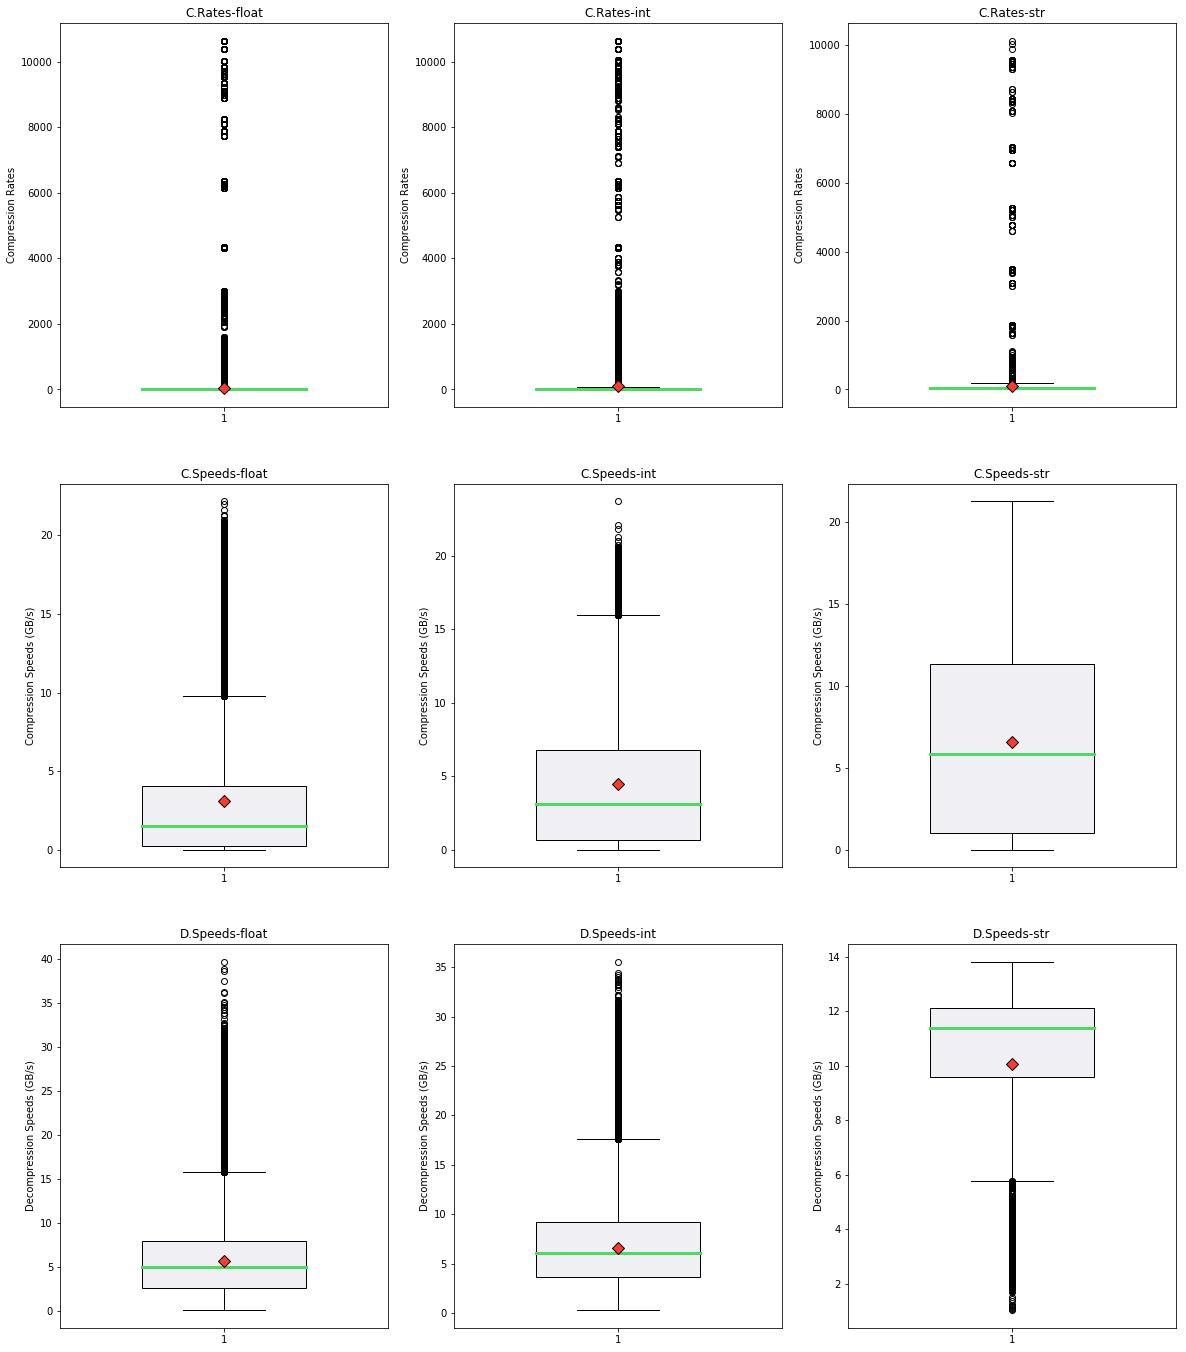

In [6]:
# -------- AUX FUNCTIONS -------- #
def boxplot_data_builder(df):
    """Build data for the boxplots."""

    rates = []
    c_speeds = []
    d_speeds = []
    indices = []
    for i in range(3):
        if i == 2:
            dfaux = df[df.DType.str.contains('U') | df.DType.str.contains('S')]
        else:
            dfaux = df[df.DType.str.contains(TYPES[i])]
        if dfaux.size > 0:
            rates.append([dfaux['CRate']])
            c_speeds.append([dfaux['CSpeed']])
            d_speeds.append([dfaux['DSpeed']])
            indices.append(i)
    return rates, c_speeds, d_speeds, indices


def paint_dtype_boxplots(df):
    """Paint boxplots structured by dtype."""

    rates, c_speeds, d_speeds, indices = boxplot_data_builder(df)
    n = len(rates)
    if n > 1:
        fig = plt.figure(figsize=(20, 24))
        for i in range(n * 3):
            aux = 300 + n * 10 + i + 1
            pos = i % n
            ax = fig.add_subplot(aux)
            if i < n:
                custom_boxplot(ax, rates[pos], 'C.Rates-' + TYPES[indices[pos]],
                               'Compression Rates')
            elif i < n * 2:
                custom_boxplot(ax, c_speeds[pos], 'C.Speeds-' + TYPES[indices[pos]],
                               'Compression Speeds (GB/s)')
            else:
                custom_boxplot(ax, d_speeds[pos], 'D.Speeds-' + TYPES[indices[pos]],
                               'Decompression Speeds (GB/s)')
        plt.show()
    else:
        fig = plt.figure(figsize=(20, 8))
        custom_boxplot(fig.add_subplot(131), rates[0],
                       'C.Rates-' + TYPES[indices[0]], 'Compression Rates')
        custom_boxplot(fig.add_subplot(132), c_speeds[0],
                       'C.Speeds-' + TYPES[indices[0]], 'Compression Speeds (GB/s)')
        custom_boxplot(fig.add_subplot(133), d_speeds[0],
                       'D.Speeds-' + TYPES[indices[0]], 'Decompression Speeds (GB/s)')
        plt.show()


# -------- AUX FUNCTIONS -------- #

paint_dtype_boxplots(my_df)

Como podemos observar aparecen muchos datos atípicos, esto es bastante normal dado que no hemos filtrado por codec, filtro ni nivel de compresión los resultados de las pruebas. Por tanto procedemos a filtrar con el codec blosclz, filtro shuffle, nivel de compresión 5 y tamaño de bloque automático para buscar con detenimiento datos atípicos.

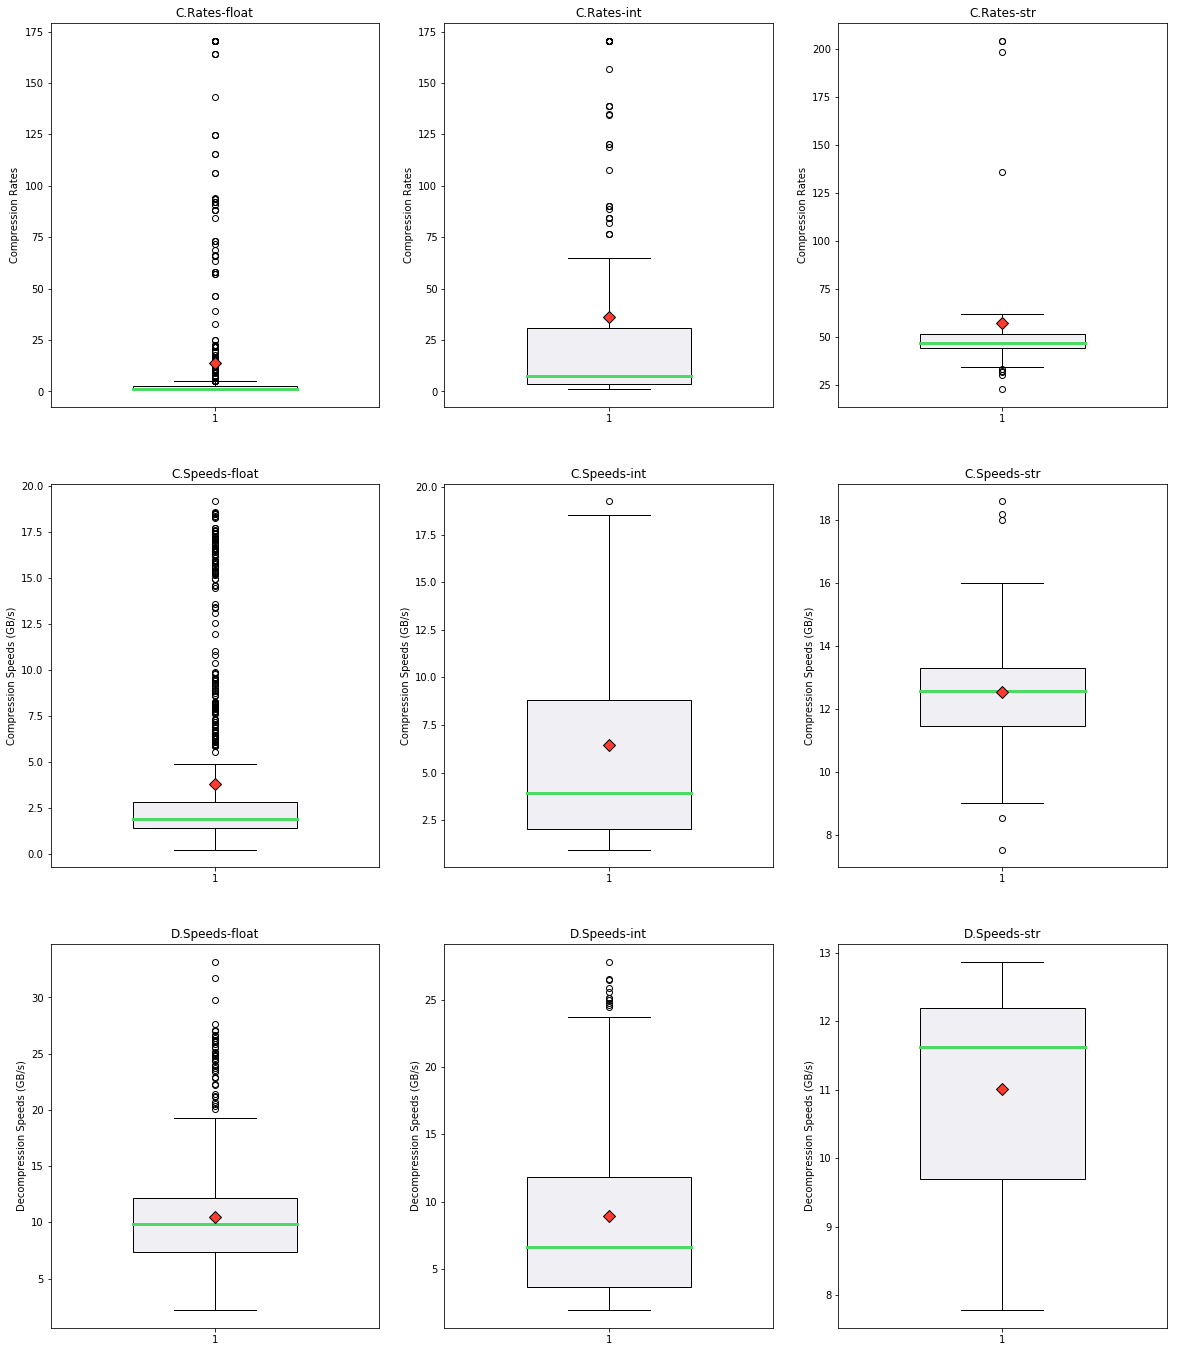

In [7]:
df_outliers = my_df[(my_df.Block_Size == 0) & (my_df.CL == 5) & (my_df.Codec == 'blosclz') & (my_df.Filter == 'noshuffle')]
paint_dtype_boxplots(df_outliers)

Mostramos a continuación los datos atípicos

In [8]:
for i in range(2):
    dfaux = df_outliers[df_outliers.DType.str.contains(TYPES[i])]
    if dfaux.size > 0:
        cr_lim = outlier_lim(dfaux['CRate'])
        cs_lim = outlier_lim(dfaux['CSpeed'])
        ds_lim = outlier_lim(dfaux['DSpeed'])
        result = dfaux[(dfaux.CRate < cr_lim[0]) | (dfaux.CRate > cr_lim[1]) |
                      (dfaux.CSpeed < cs_lim[0]) | (dfaux.CSpeed > cs_lim[1]) |
                      (dfaux.DSpeed < ds_lim[0]) | (dfaux.DSpeed > ds_lim[1])][DESC_ALL]
        if result.size > 0:
            print('%d %s OUTLIERS' % (result.shape[0], TYPES[i].upper()))
            display(result)

153 FLOAT OUTLIERS


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3,CRate,CSpeed,DSpeed
421925,16.000000,0.014364,0.00,0.136009,26.700748,1452.235532,0.0,21.841198,0.00,0.00,21.451223,9.263039,13.231577
422825,16.000000,0.000000,0.00,0.000000,0.000000,-3.000000,0.0,0.000000,0.00,0.00,170.638893,18.471251,24.758595
423725,16.000000,0.000000,0.00,0.000000,0.000000,-3.000000,0.0,0.000000,0.00,0.00,170.638893,18.342010,26.980650
424625,16.000000,0.093882,0.00,1.058057,26.874855,1731.911427,0.0,210.768570,0.00,0.00,12.637024,7.914020,13.693272
427325,16.000000,0.019793,0.00,0.300986,26.478577,1032.814904,0.0,36.053143,0.00,0.00,46.348333,13.562914,18.783606
428225,16.000000,0.000000,0.00,0.000000,0.000000,-3.000000,0.0,0.000000,0.00,0.00,170.638893,17.702863,26.608201
429125,16.000000,0.000000,0.00,0.000000,0.000000,-3.000000,0.0,0.000000,0.00,0.00,170.638893,16.633503,24.843063
430025,16.000000,0.160483,0.00,0.919033,18.265038,869.841296,0.0,164.261734,0.00,0.00,4.728078,6.089574,14.658018
432725,16.000000,0.001129,0.00,0.041174,108.762825,21889.348348,0.0,14.807006,0.00,0.00,106.104997,16.886369,26.047695
433625,16.000000,0.000000,0.00,0.000000,0.000000,-3.000000,0.0,0.000000,0.00,0.00,170.638893,15.205568,23.865987


36 INT OUTLIERS


,Chunk_Size,Mean,Median,Sd,Skew,Kurt,Min,Max,Q1,Q3,CRate,CSpeed,DSpeed
362525,2.445312,0.000493,0.0,0.026667,99.484580,18684.148011,0.0,8.0,0.0,0.0,156.815852,9.946375,18.898113
369725,2.445312,0.001732,0.0,0.054644,50.615793,3993.813141,0.0,8.0,0.0,0.0,134.316186,8.531516,11.938021
380525,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,170.638893,16.433300,15.822308
391325,2.445312,0.001457,0.0,0.045286,47.236910,3683.631977,0.0,7.0,0.0,0.0,135.187220,7.942902,12.304668
406625,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,170.638893,18.544426,25.128834
407525,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,170.638893,18.393489,25.842271
412025,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,170.638893,18.466047,24.758595
412925,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,170.638893,17.823225,23.693420
416525,16.000000,0.016557,0.0,0.467508,41.151722,2111.448576,0.0,63.0,0.0,0.0,120.435996,17.088918,22.490048
417425,16.000000,0.000000,0.0,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,170.638893,17.678986,21.671958


No mostramos los datos atípicos de tipo string dado que no extraemos ninguna característica de chunk que podamos comentar, nos centraremos en ellos cuando busquemos correlaciones entre blosclz y el resto de codecs.  
En cuanto a los datos atípicos observamos que la mayoría son series números idénticos o muy parecidos, siempre con un rango intercuartílico de 0.

## Correlaciones Block Size
Aquí pretendemos observar la correlación entre el tamaño de bloque y las medidas de compresión, para ello filtramos los datos por tipo, codec, filtro, nivel de compresión y tamaño de bloque; y calculamos la media de su ratio de compresión y velocidades de compresión/decompresión.

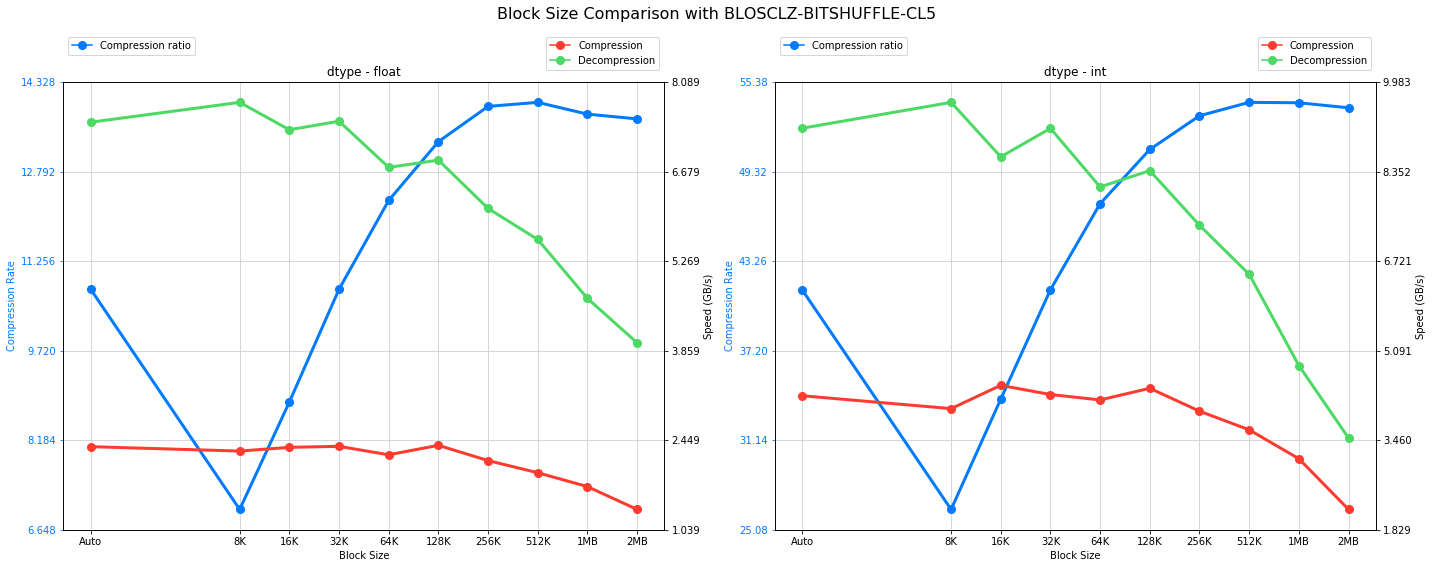

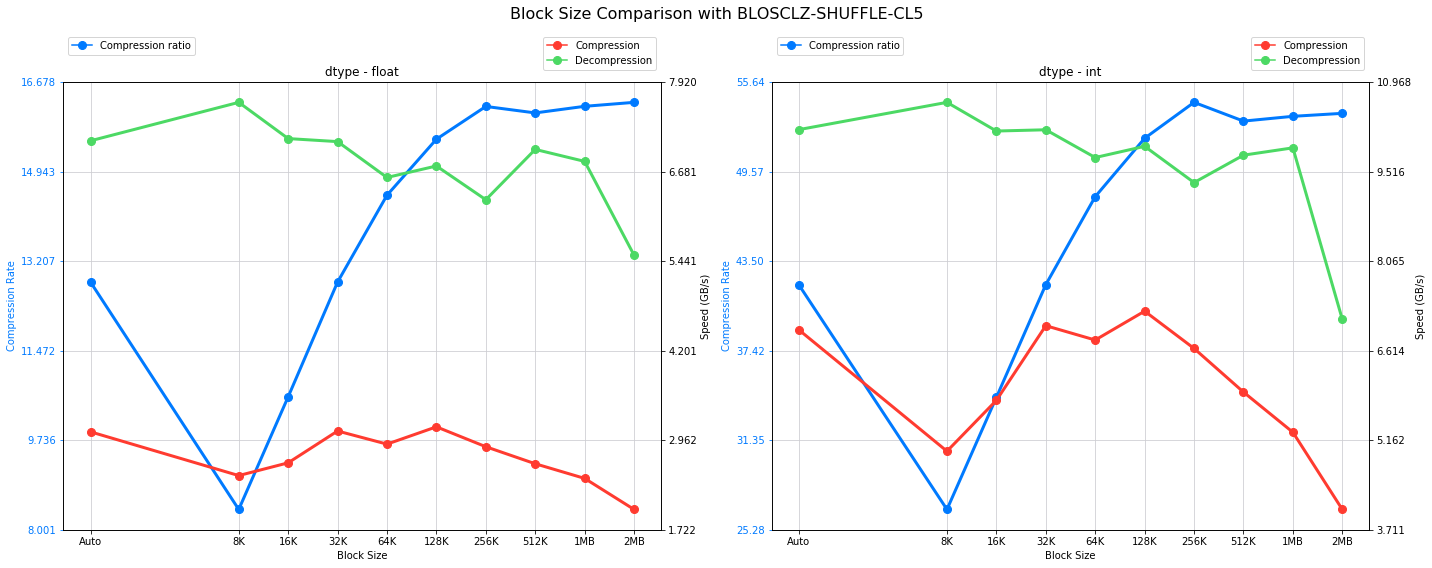

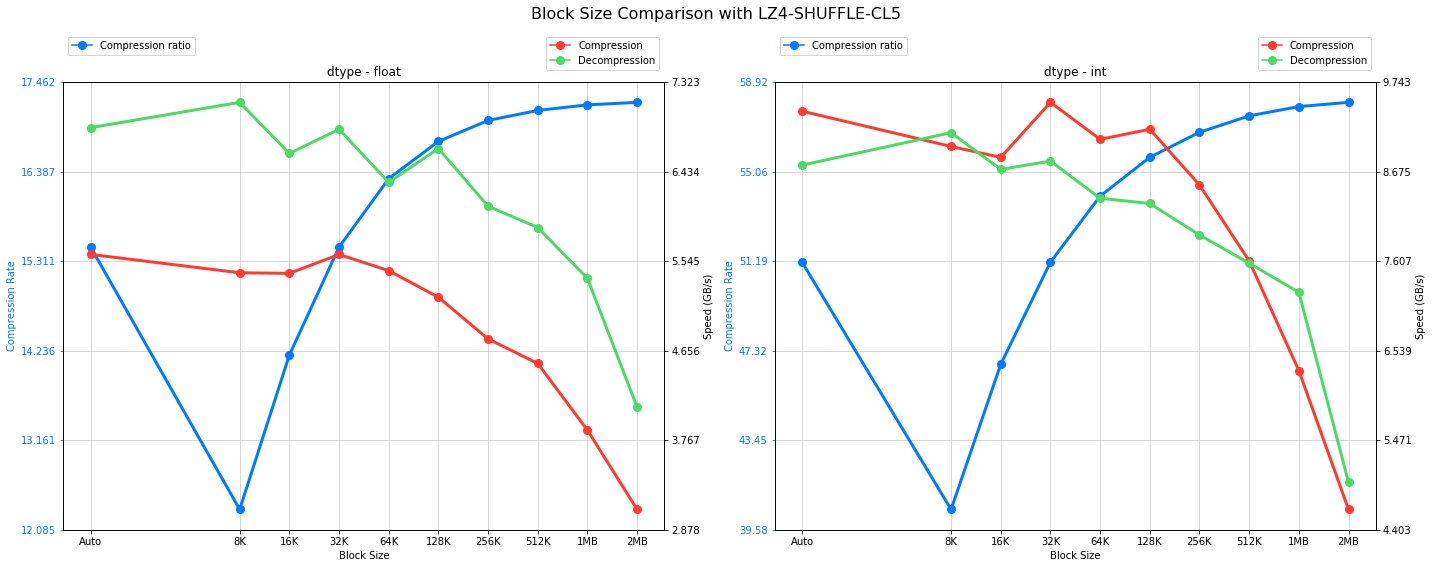

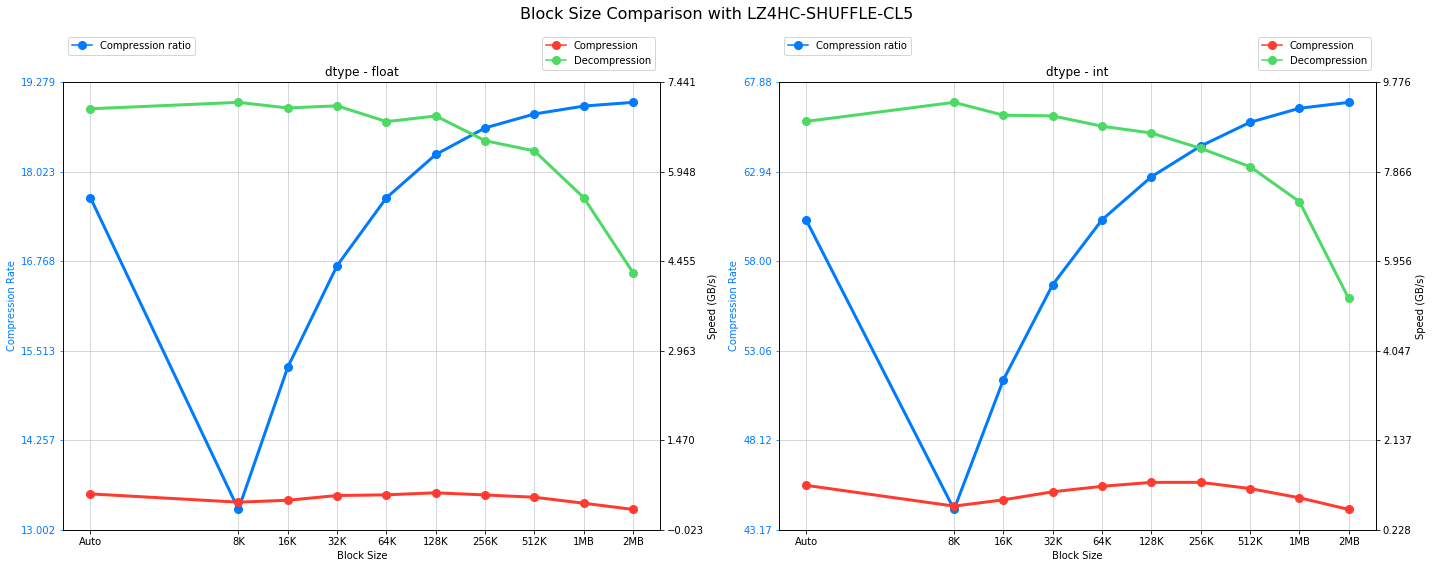

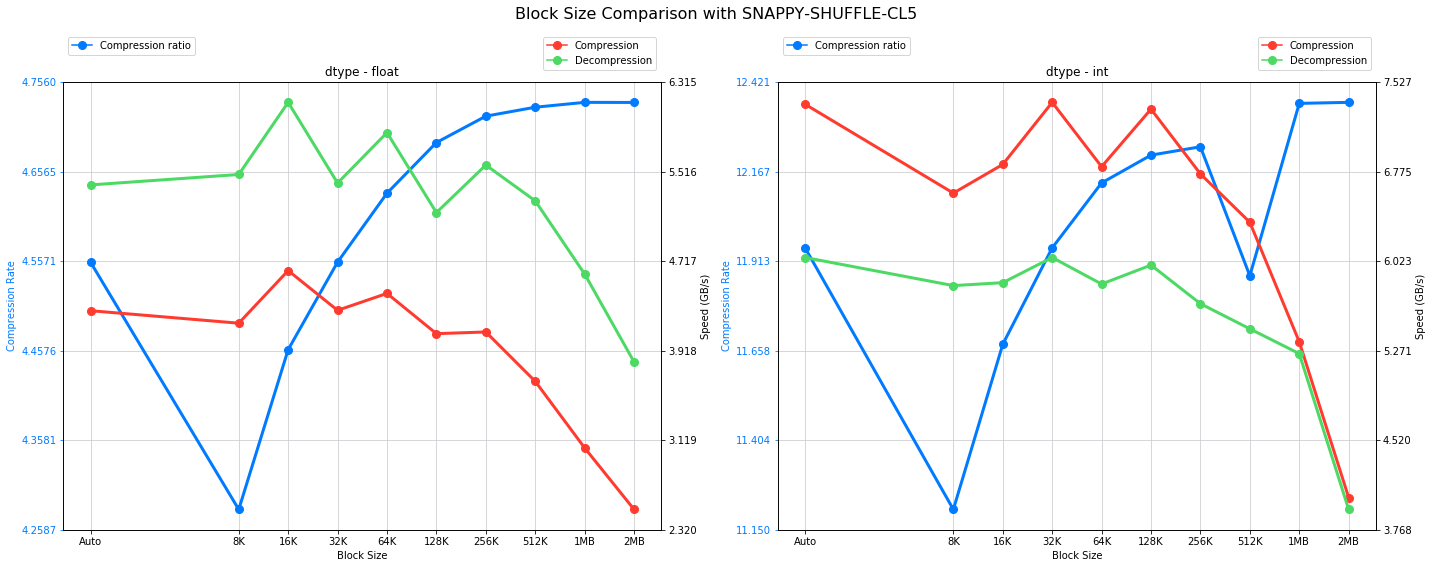

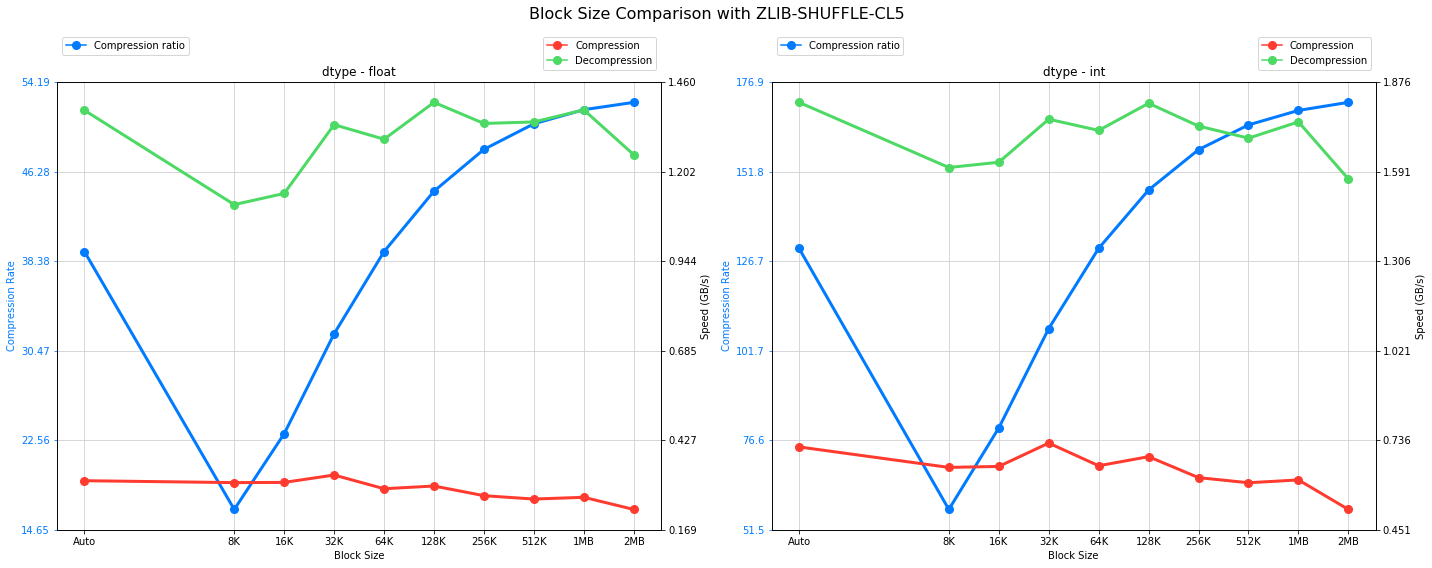

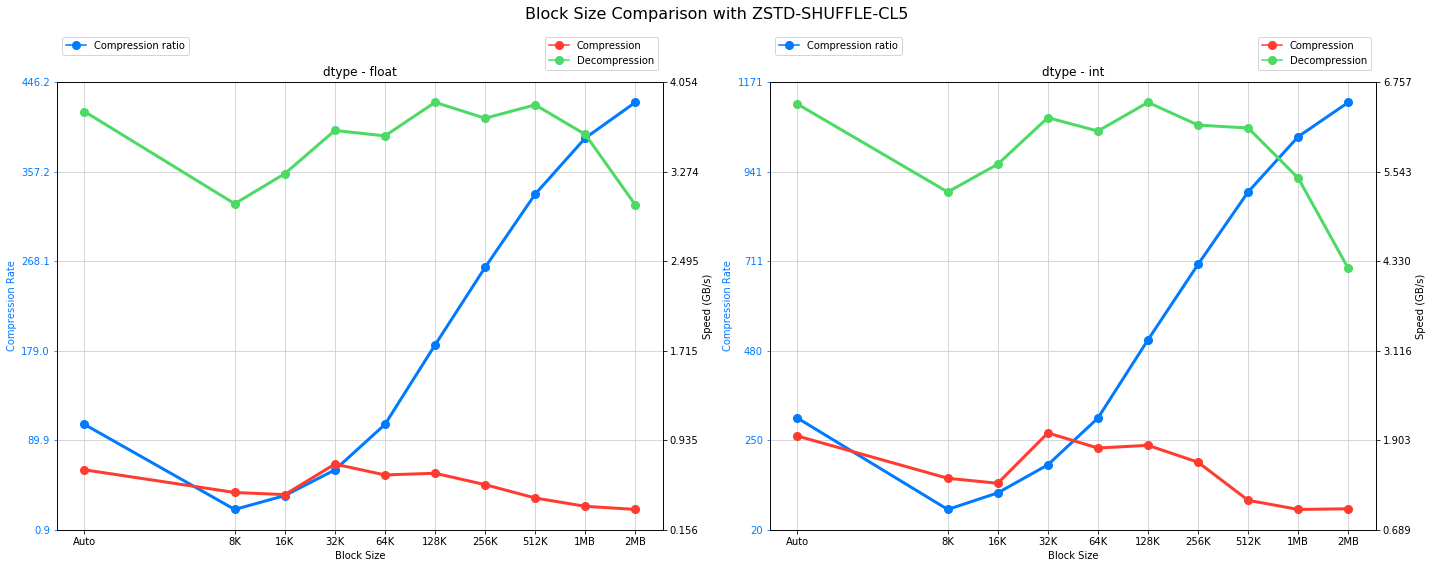

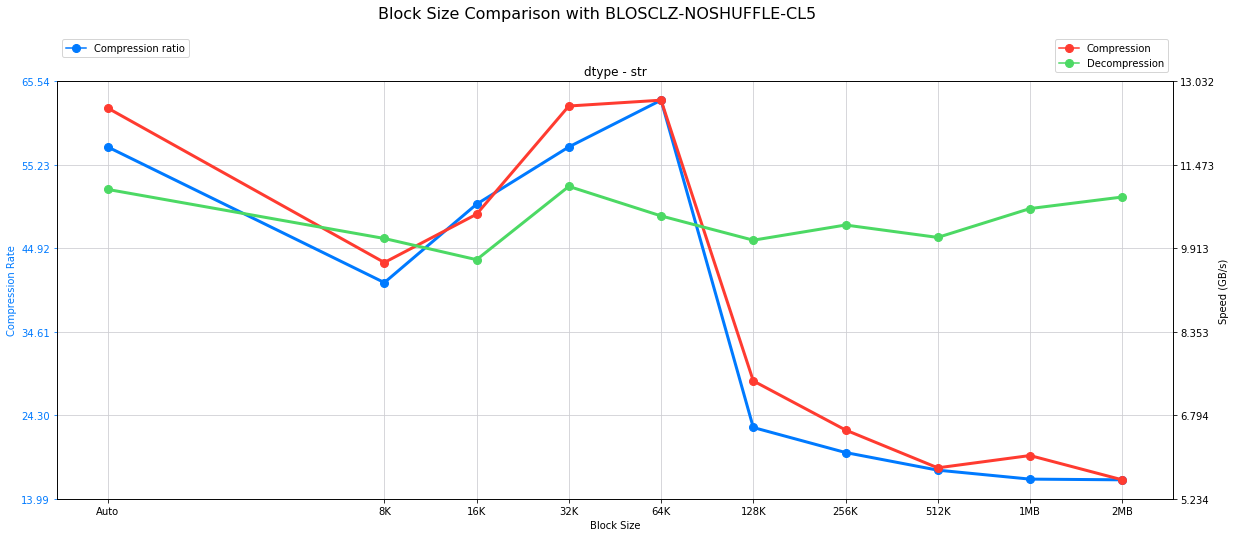

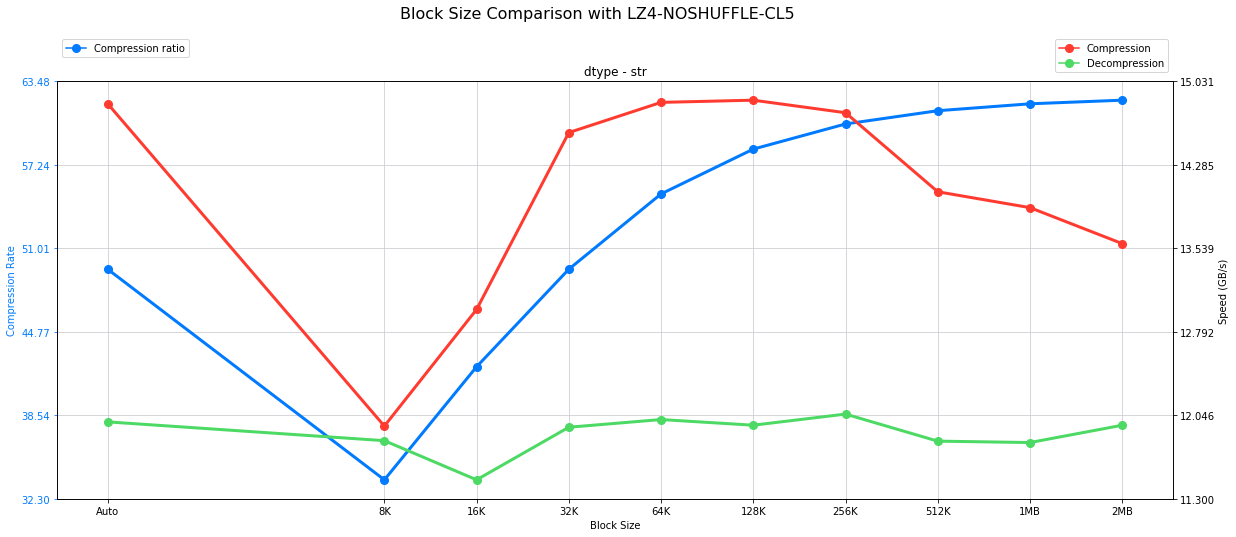

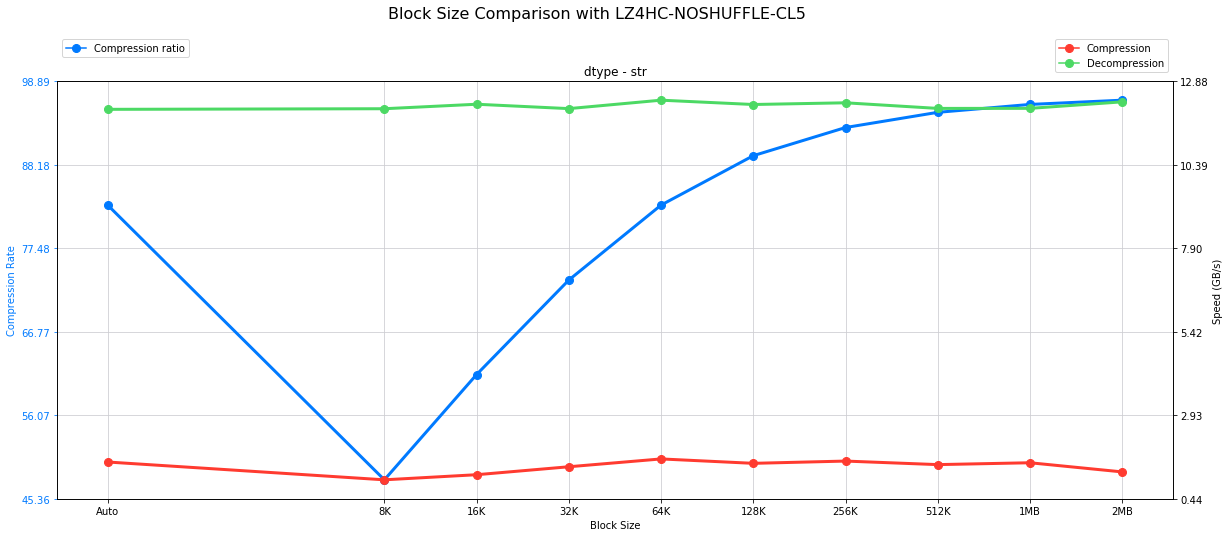

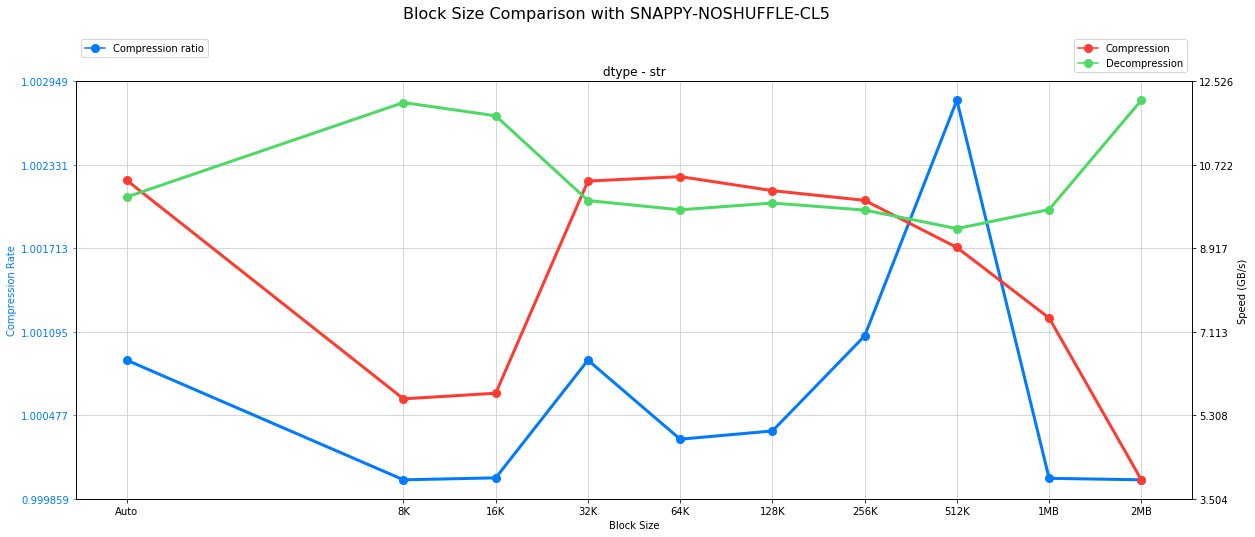

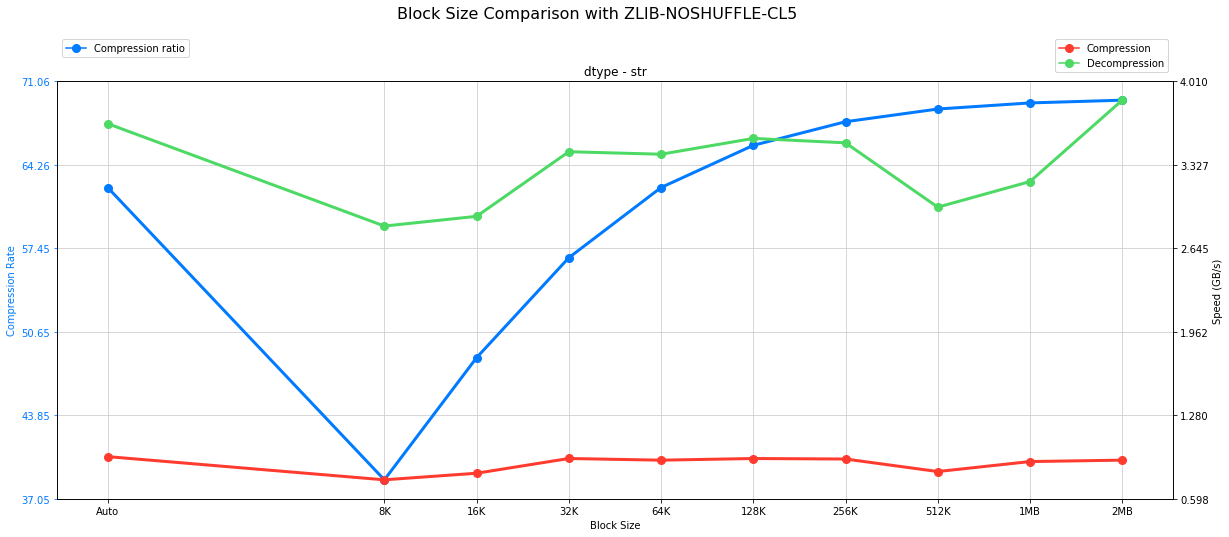

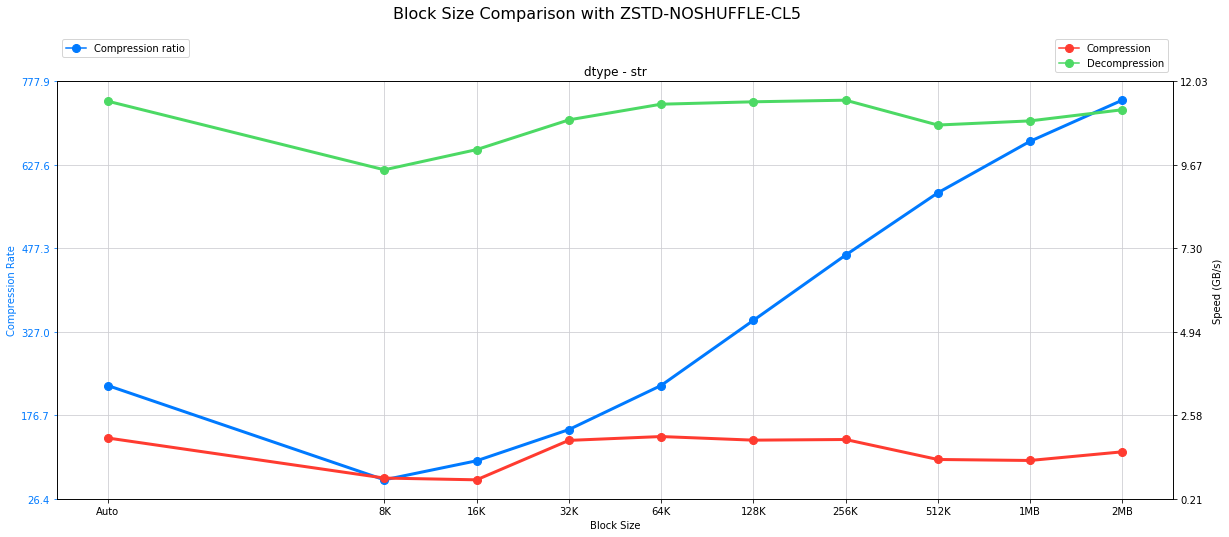

In [9]:
def block_cor_data_builder(df, onlystr, cl_mode):
    """Build data for the block correlation graphs"""

    rates = []
    c_speeds = []
    d_speeds = []
    indices = []
    block_values = [0] + BLOCK_SIZES
    if onlystr:
        options = [2]
    else:
        options = range(3)
    for i in options:
        if i == 2:
            dfaux = df[df.DType.str.contains('U') | df.DType.str.contains('S')]
        else:
            dfaux = df[df.DType.str.contains(TYPES[i])]
        if dfaux.size > 0:
            if not cl_mode:
                rates.append([dfaux[dfaux.Block_Size == size]['CRate'].mean() for size in block_values])
                c_speeds.append([dfaux[dfaux.Block_Size == size]['CSpeed'].mean() for size in block_values])
                d_speeds.append([dfaux[dfaux.Block_Size == size]['DSpeed'].mean() for size in block_values])
                indices.append(i)
            else:
                rates.append([dfaux[dfaux.CL == cl]['CRate'].mean() for cl in list(range(10))[1:]])
                c_speeds.append([dfaux[dfaux.CL == cl]['CSpeed'].mean() for cl in list(range(10))[1:]])
                d_speeds.append([dfaux[dfaux.CL == cl]['DSpeed'].mean() for cl in list(range(10))[1:]])
                indices.append(i)

    return rates, c_speeds, d_speeds, indices


def paint_block_cor(df, title='', onlystr=False, cl_mode=False):
    """Paint custom lineplots structured by dtype."""

    rates, c_speeds, d_speeds, indices = block_cor_data_builder(df, onlystr, cl_mode)
    if not cl_mode:
        x = [1] + BLOCK_SIZES
    else:
        x = list(range(10))[1:]
    n = len(rates)
    fig = plt.figure(figsize=(20, 8))
    fig.suptitle('Block Size Comparison with ' + title, fontsize=16)
    for i in range(n):
        pos = 100 + n * 10 + i + 1
        ax = fig.add_subplot(pos)
        custom_lineplot_tests(ax, x, rates=rates[i], c_speeds=c_speeds[i],
                              d_speeds=d_speeds[i], title='dtype - ' + TYPES[indices[i]], cl_mode=cl_mode)
    if n > 1:
        fig.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


def paint_all_block_cor(filter_name, c_level=5, cl_mode=False, block_size=0):
    """Paint all custom lineplots for filter."""

    if filter_name == 'noshuffle':
        onlystr = True
    else:
        onlystr = False
    for codec in my_df.drop_duplicates(subset=['Codec'])['Codec']:
        if codec == 'blosclz' and filter_name == 'shuffle':
            if not cl_mode:
                paint_block_cor(my_df[(my_df.CL == c_level) & (my_df.Codec == codec) & (my_df.Filter == 'bitshuffle')],
                                codec.upper() + '-BITSHUFFLE-CL' + str(c_level), onlystr, cl_mode)
            else:
                paint_block_cor(
                    my_df[(my_df.Block_Size == block_size) & (my_df.Codec == codec) & (my_df.Filter == 'bitshuffle')],
                    codec.upper() + '-BITSHUFFLE-BLOCK' + str(block_size), onlystr, cl_mode)
        if not cl_mode:
            paint_block_cor(my_df[(my_df.CL == c_level) & (my_df.Codec == codec) & (my_df.Filter == filter_name)],
                            codec.upper() + '-' + filter_name.upper() + '-CL' + str(c_level), onlystr, cl_mode)
        else:
            paint_block_cor(
                my_df[(my_df.Block_Size == block_size) & (my_df.Codec == codec) & (my_df.Filter == filter_name)],
                codec.upper() + '-' + filter_name.upper() + '-BLOCK' + str(block_size), onlystr, cl_mode)


def paint_cl_comparison(filter_name, codec):
    data = []
    for c_level in [1, 3, 6, 9]:
        data.append(block_cor_data_builder(my_df[(my_df.CL == c_level)
                                                 & (my_df.Codec == codec) & (my_df.Filter == filter_name)], False,
                                           False))
    block_sizes = [1] + BLOCK_SIZES
    n = len(data[0][0])
    for i in range(n):
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Compression level comparison ' + TYPES[data[0][3][i]].upper(), fontsize=16)
        for j in range(4):
            pos = 200 + 20 + j + 1
            ax = fig.add_subplot(pos)
            custom_lineplot_tests(ax, block_sizes, data[j][0][i], data[j][1][i], data[j][2][i],
                                  title='C-Level ' + str(j * 3))
        if n > 1:
            fig.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()


paint_all_block_cor('shuffle')
paint_all_block_cor('noshuffle')

# Comparación de niveles de compresión
Al igual que antes pero con el nivel de compresión como añadido realizamos previamente una gráfica en la que mantenemos la correlación con el tamaño de bloque pero mostramos sus gráficas en 4 niveles de compresión distintos.

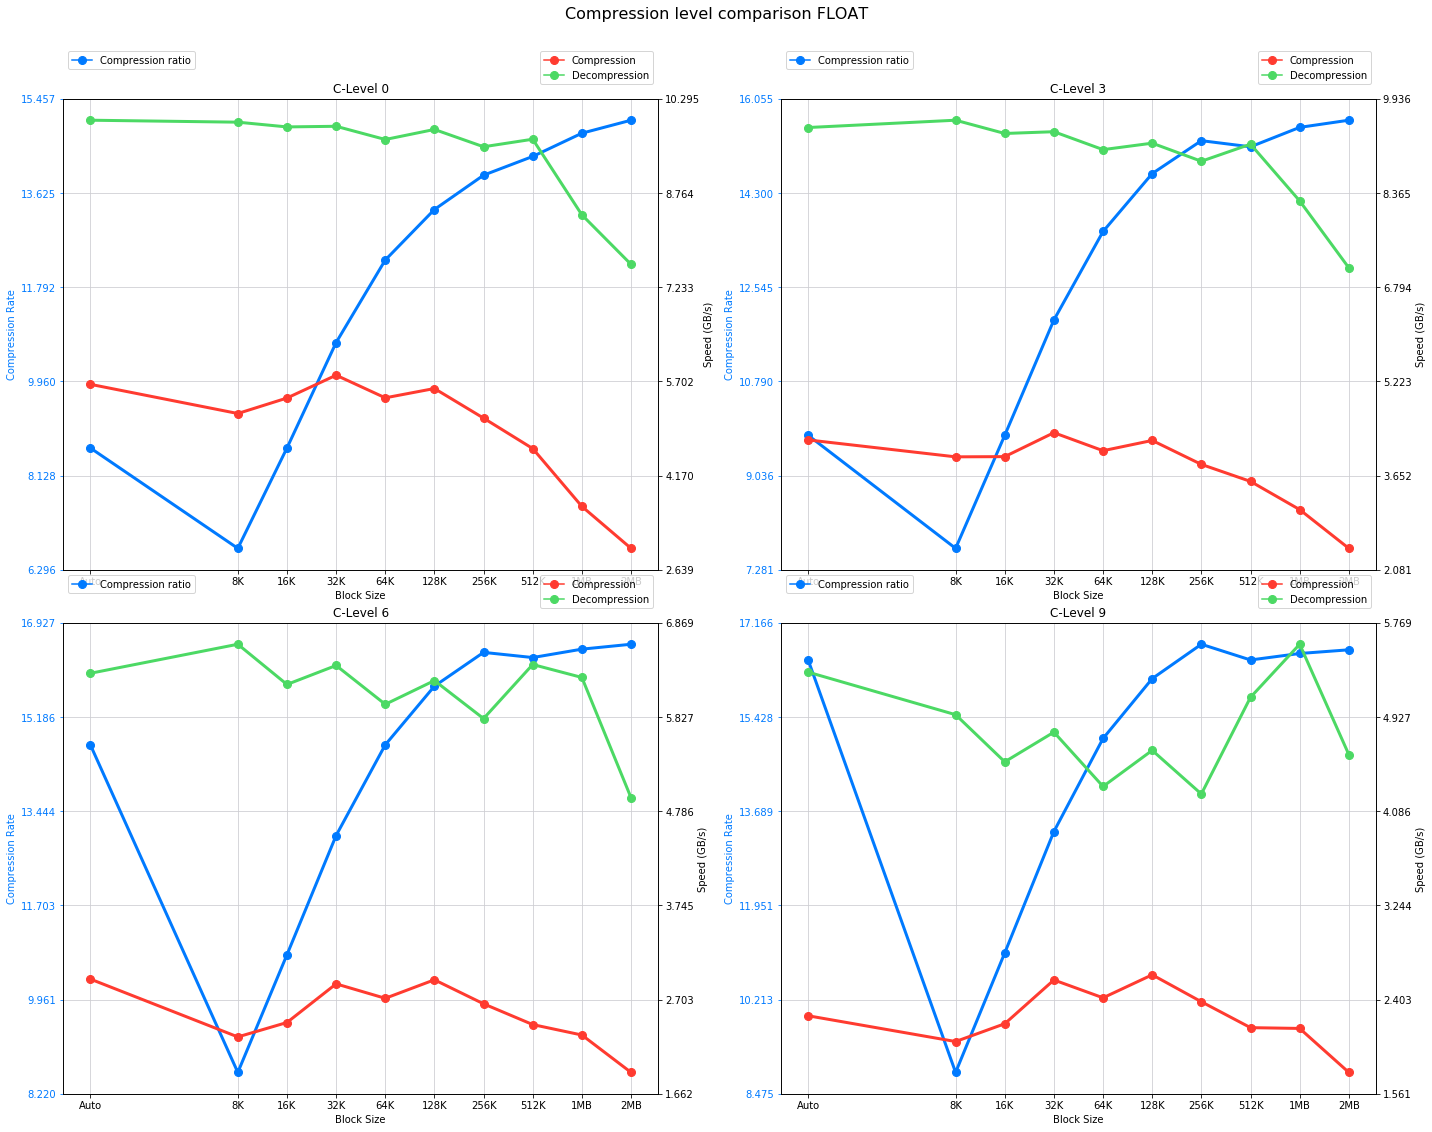

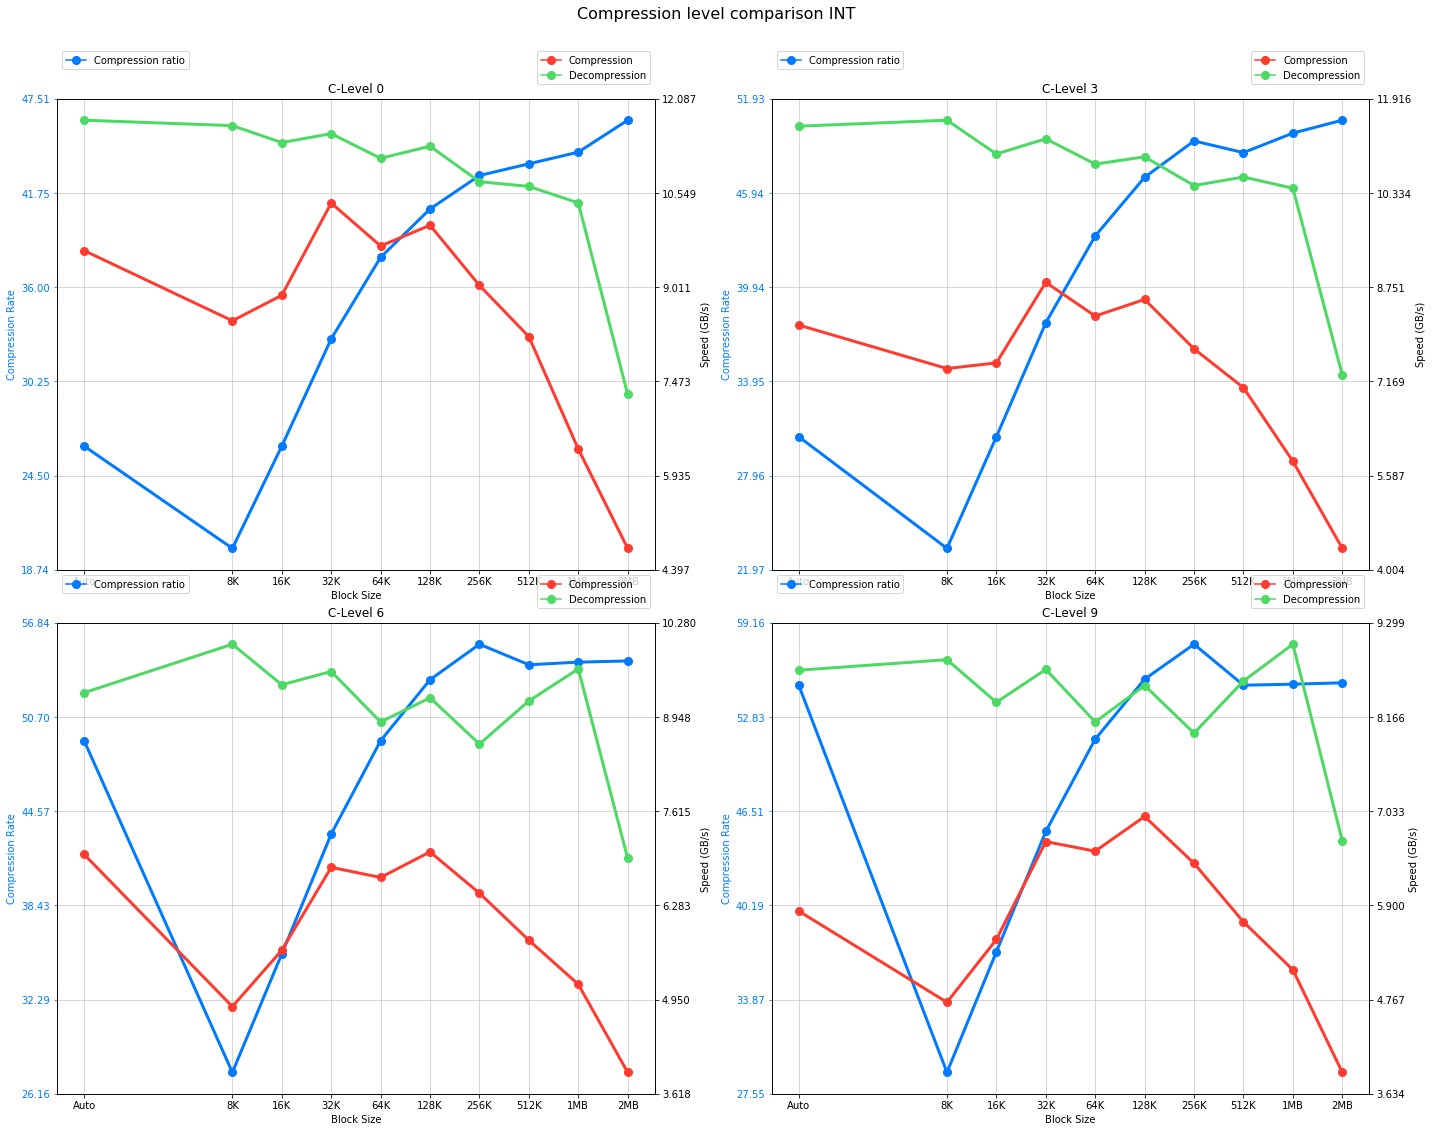

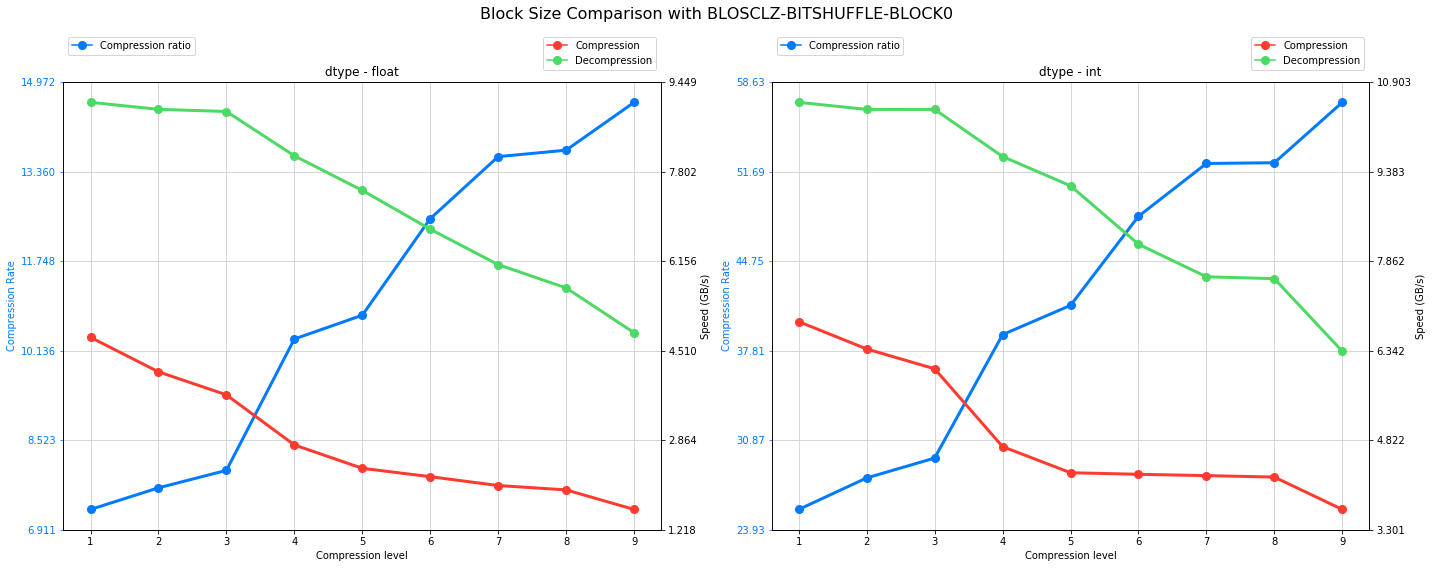

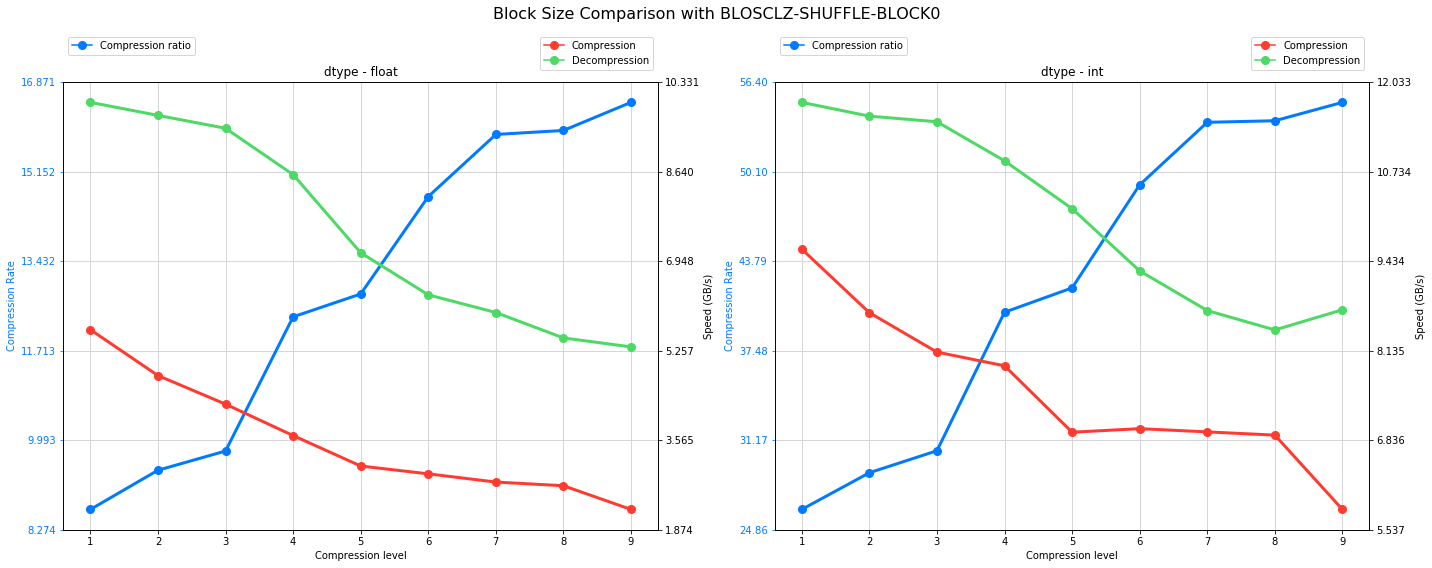

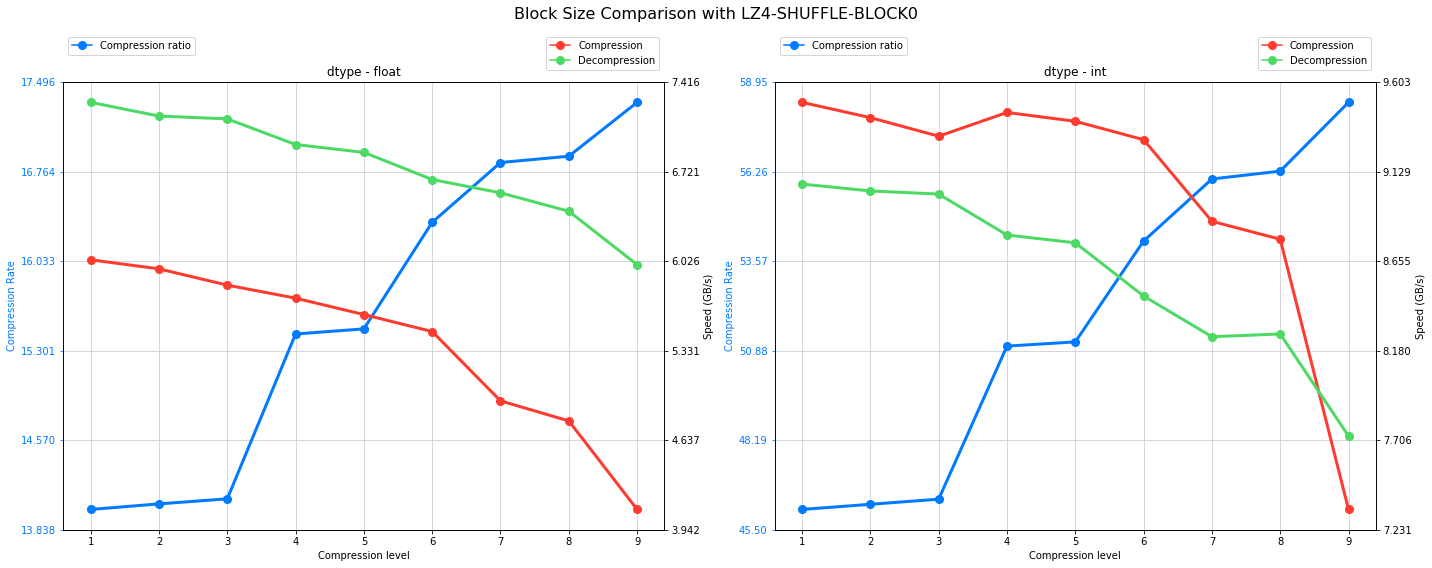

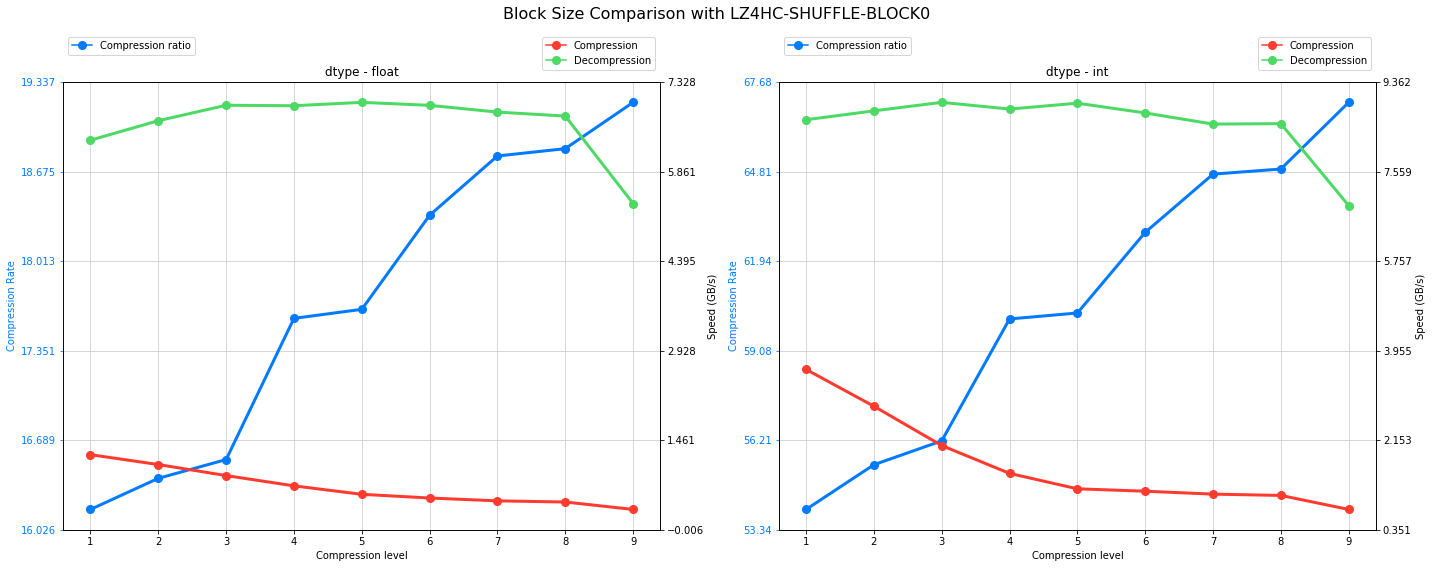

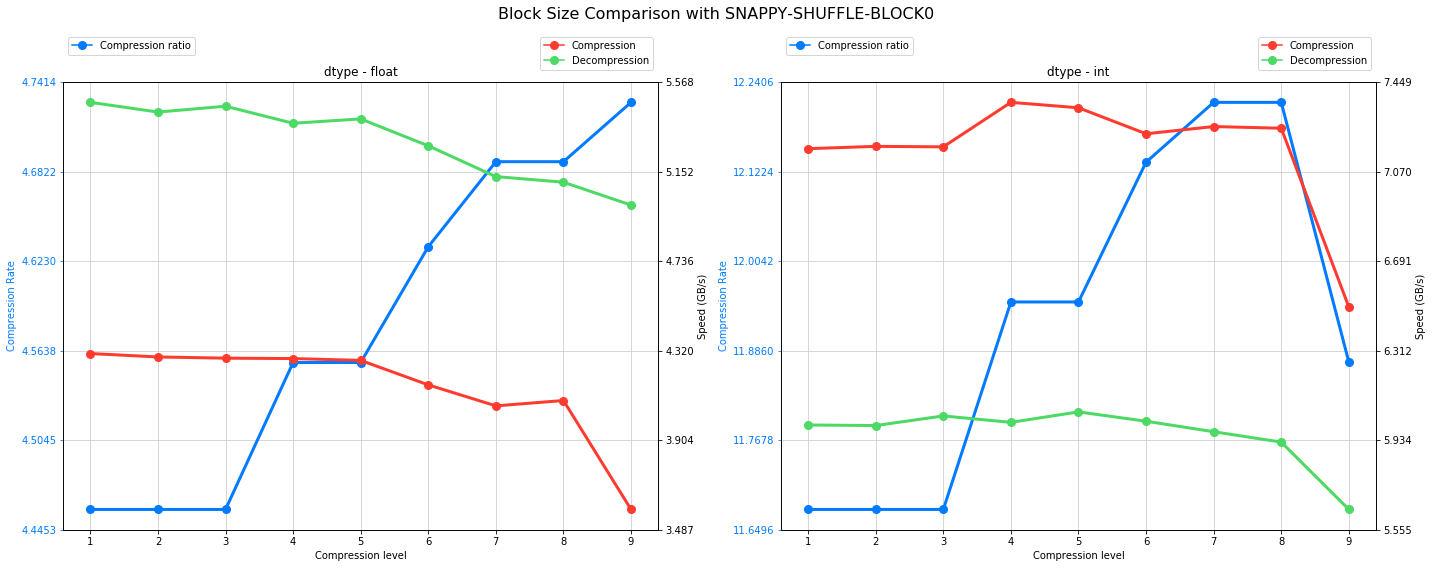

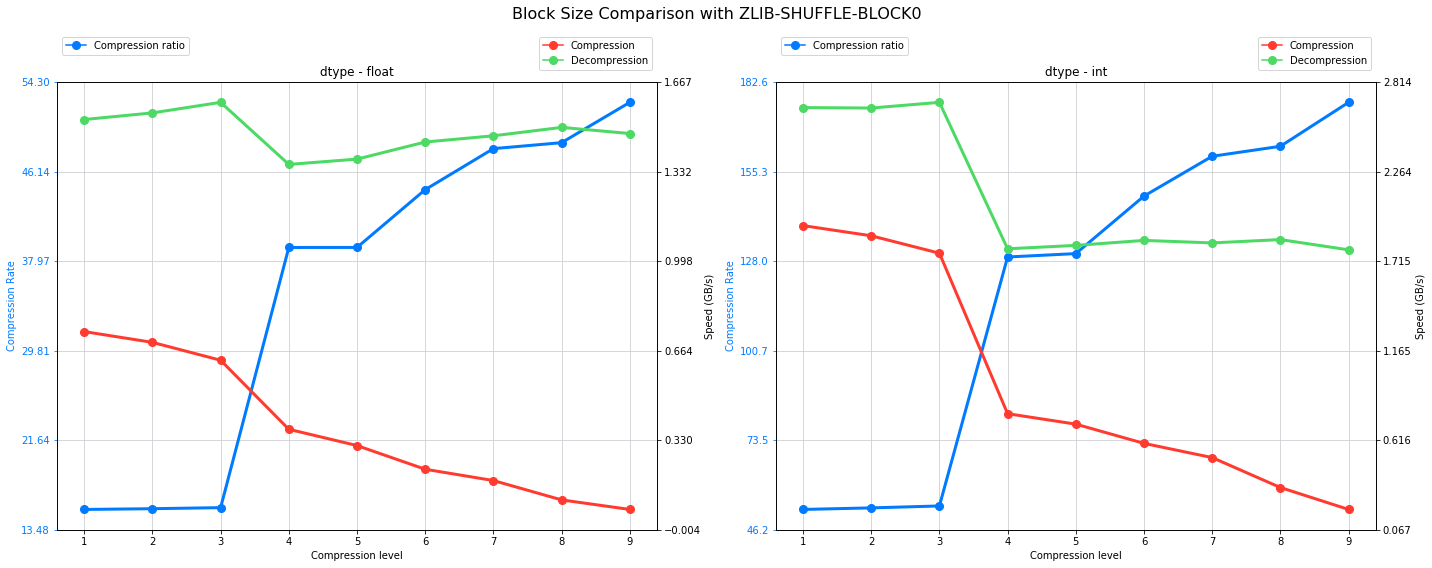

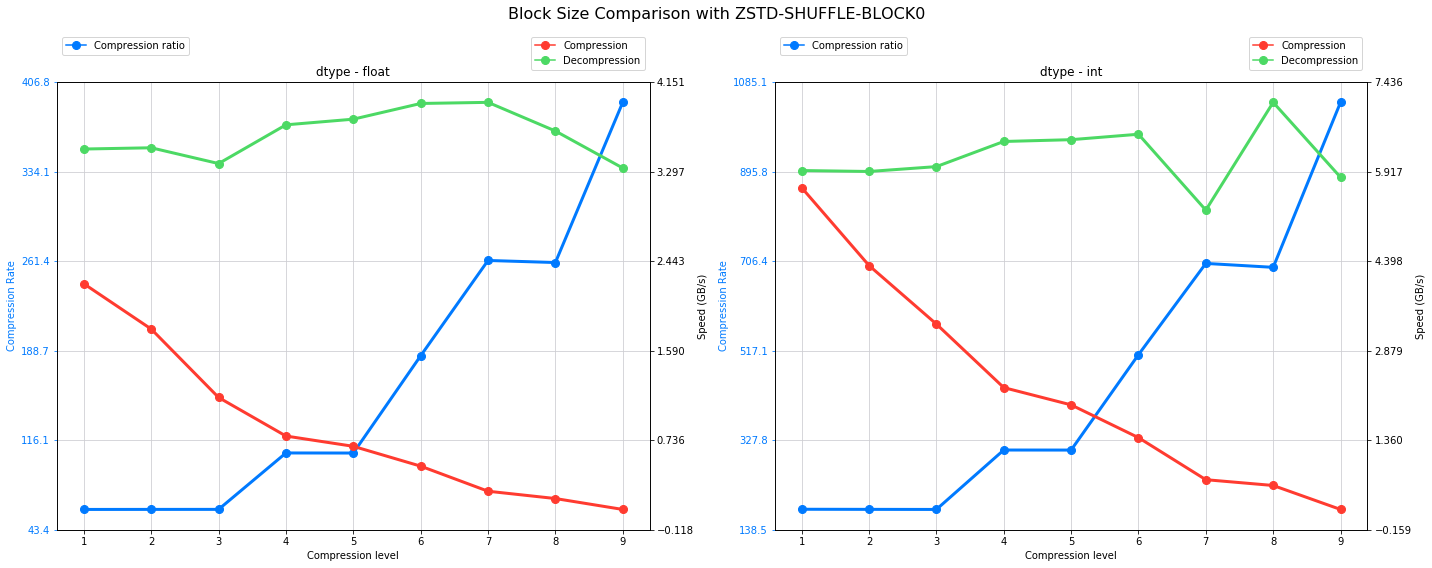

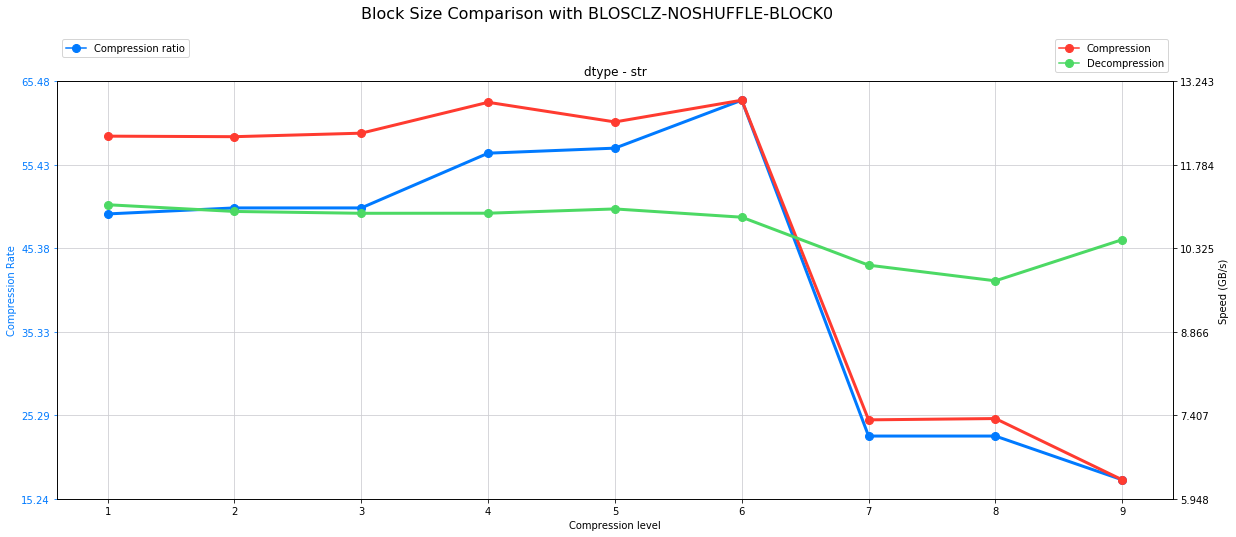

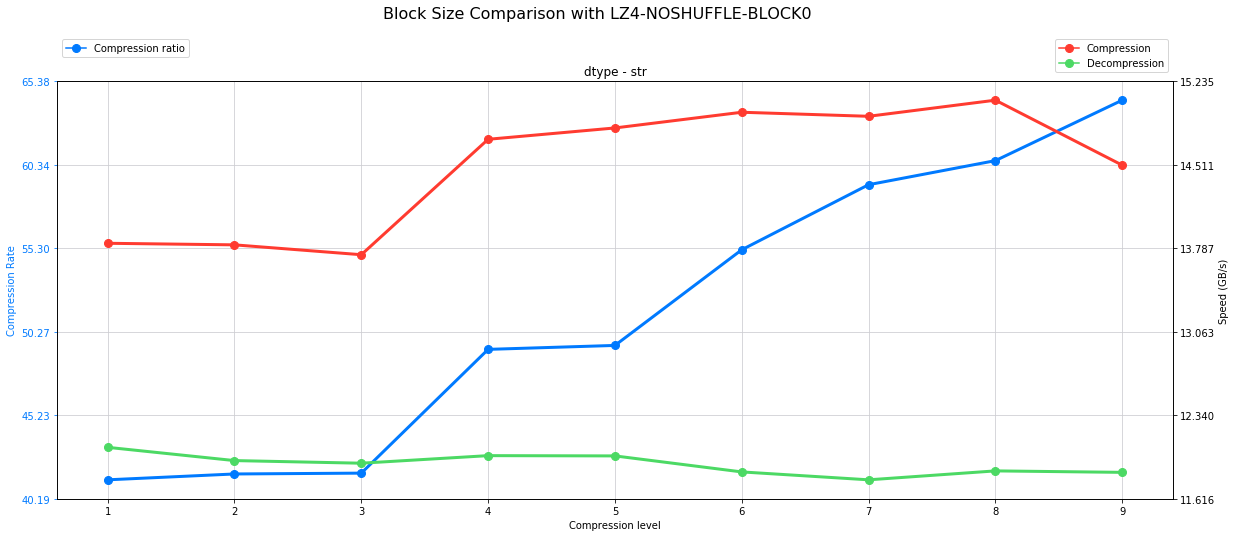

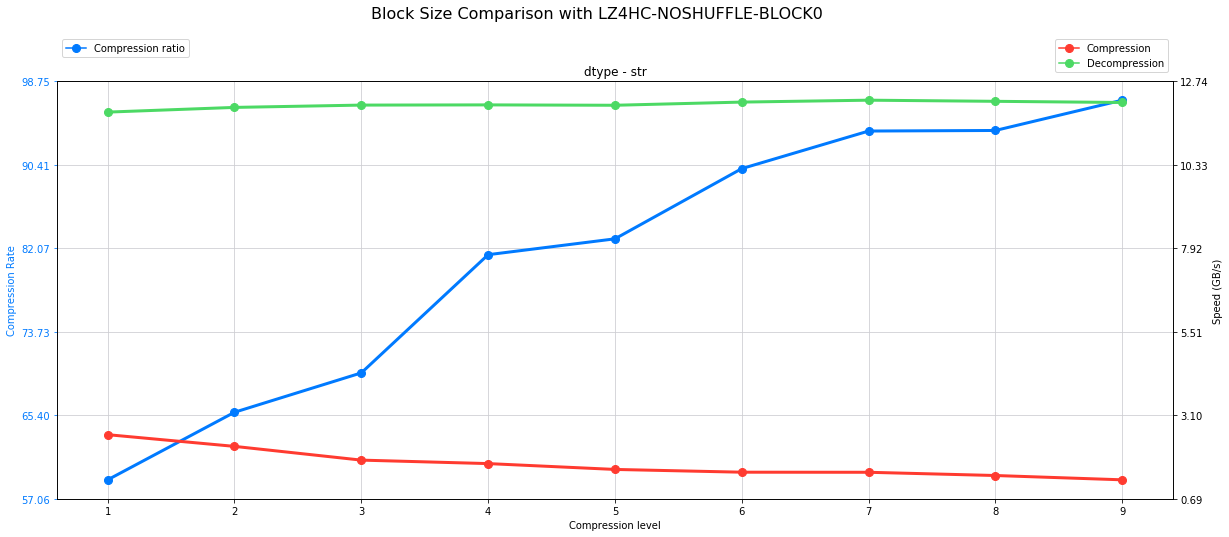

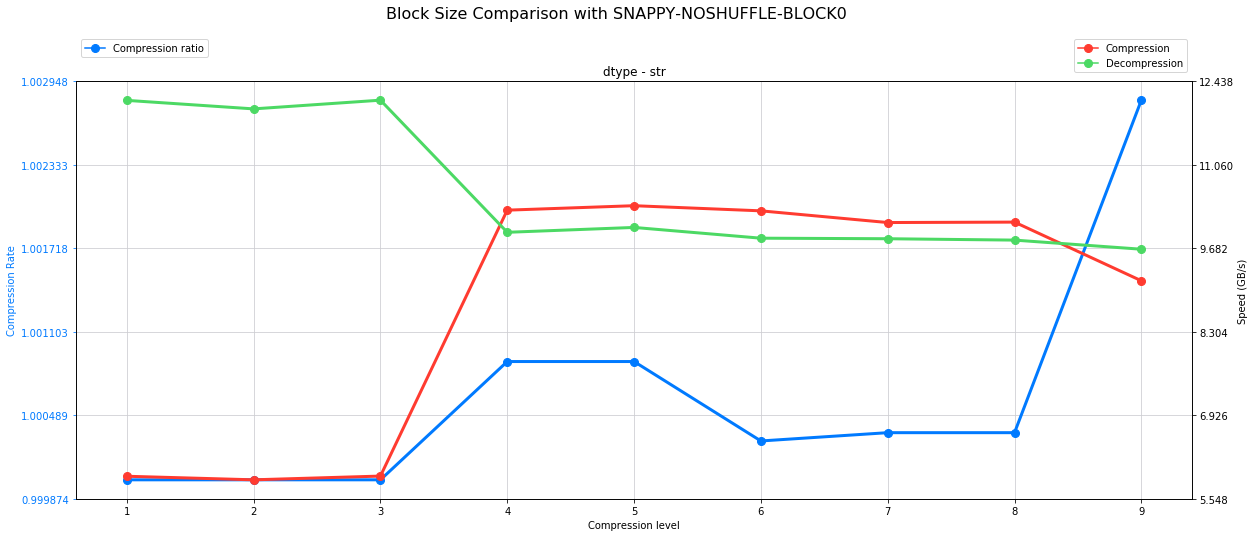

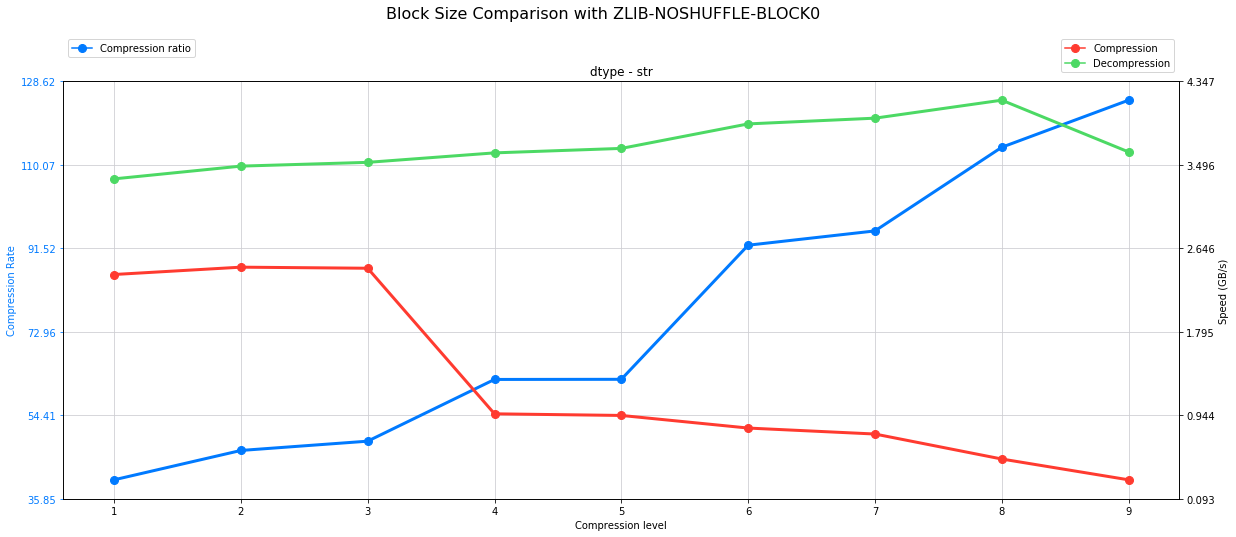

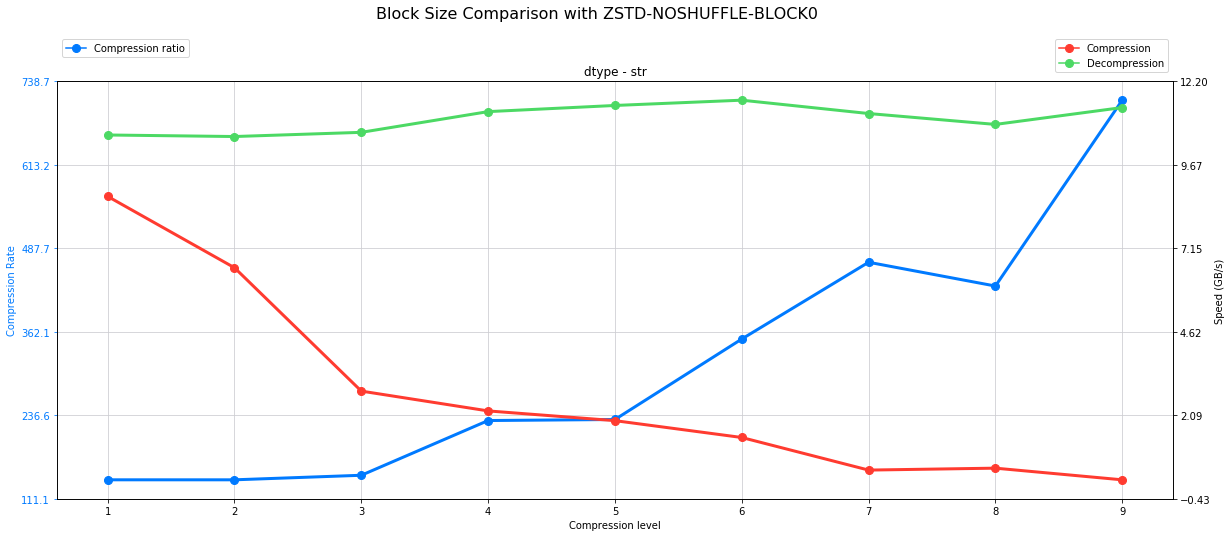

In [10]:
paint_cl_comparison('shuffle', 'blosclz')
paint_all_block_cor('shuffle', cl_mode=True)
paint_all_block_cor('noshuffle', cl_mode=True)

## Tablas columnares VS Tablas normales
En el caso de que los datos esten en forma de tabla, si la tabla contiene más de una columna se realizan dos pruebas de compresión, una guardando los datos como tabla normal, fila por fila y otra guardándolos columnarmente.

In [11]:
df_col = my_df[my_df.Table == 2]
if df_col.size > 0:
    sets = df_col.drop_duplicates(subset=['DataSet'])
    for dataset in sets['DataSet']:
        dfaux = my_df[my_df.DataSet == dataset]
        normal_table = dfaux[dfaux.Table == 1][DESC_TEST]
        normal_table.columns = ['N_CRate', 'N_CSpeed', 'N_DSpeed']
        col_table = dfaux[dfaux.Table == 2][DESC_TEST]
        col_table.columns = ['COL_CRate', 'COL_CSpeed', 'COL_DSpeed']
        result = pd.concat([normal_table, col_table])
        result = result[['N_CRate', 'COL_CRate', 'N_CSpeed', 'COL_CSpeed','N_DSpeed', 'COL_DSpeed']]
        print(sets[sets.DataSet == dataset][DESC_SET])
        display(result.describe())

                           DataSet    DType  Table  Chunk_Size
807300  /msft/table.values_block_0  float64    2.0        16.0


,N_CRate,COL_CRate,N_CSpeed,COL_CSpeed,N_DSpeed,COL_DSpeed
count,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000
mean,9.579305,16.431990,2.797430,2.965286,5.767018,5.132630
std,7.501615,32.003566,3.377365,3.456482,3.918794,3.397750
min,0.999989,0.999989,0.001743,0.000665,0.338483,0.319464
25%,3.543336,3.980350,0.366209,0.351423,2.439230,2.504170
50%,8.079971,7.283675,1.419358,1.775609,4.411268,4.109227
75%,13.825371,15.174322,3.708753,4.023946,9.092120,6.817435
max,38.852966,296.254984,11.993684,15.111406,24.877729,23.541322


                           DataSet DType  Table  Chunk_Size
820800  /msft/table.values_block_2  |S49    2.0   15.999992


,N_CRate,COL_CRate,N_CSpeed,COL_CSpeed,N_DSpeed,COL_DSpeed
count,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000
mean,47.229933,132.799279,6.368114,6.850604,10.171562,9.930717
std,45.351562,697.751611,5.293652,5.574635,3.080946,2.987211
min,0.999997,0.999997,0.008533,0.009674,1.025169,1.521827
25%,1.000782,1.000794,1.047608,1.020901,9.781488,9.351594
50%,42.859189,43.002494,5.624439,6.471090,11.576748,11.218071
75%,68.192622,82.251901,11.342818,11.398055,12.189853,12.022742
max,232.842146,10131.164251,19.510559,21.291738,13.826154,13.782538


## Correlaciones Blosclz-CL1 VS Otros
Para poder visualizar todas estas correlaciones calculamos directamente el coeficiente de pearson y su p-valor asociado entre los datos de blosclz con nivel de compresión 1 y el resto.

blosclz 1 VS


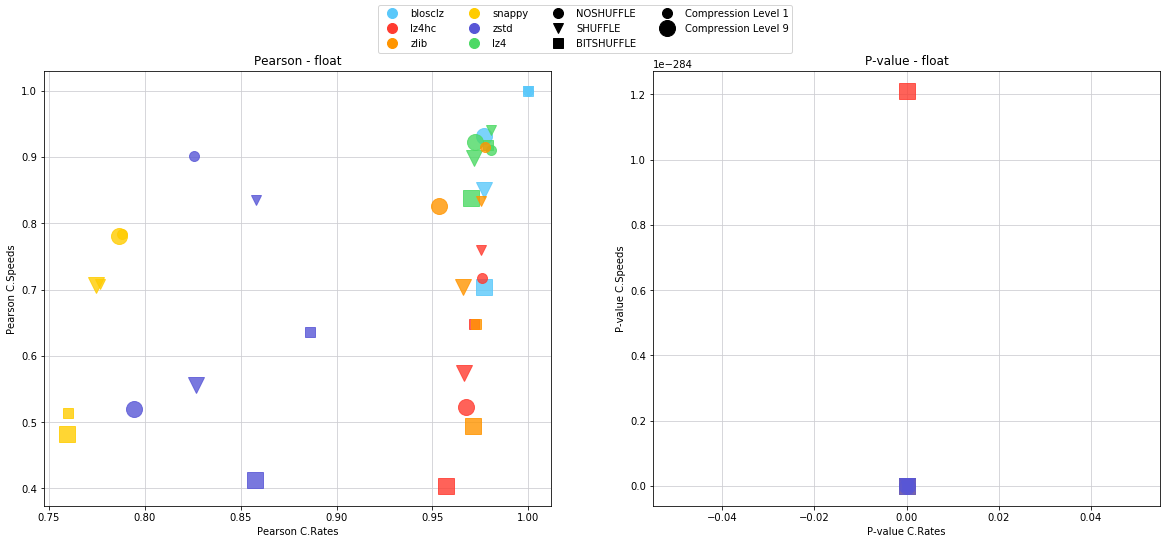

blosclz 1 VS


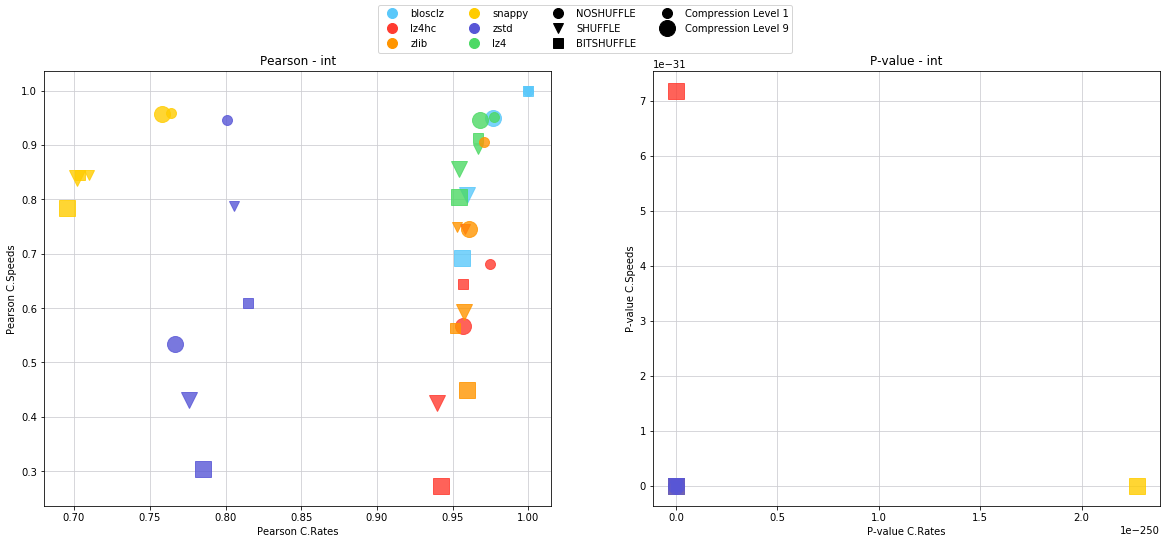

blosclz 1 VS


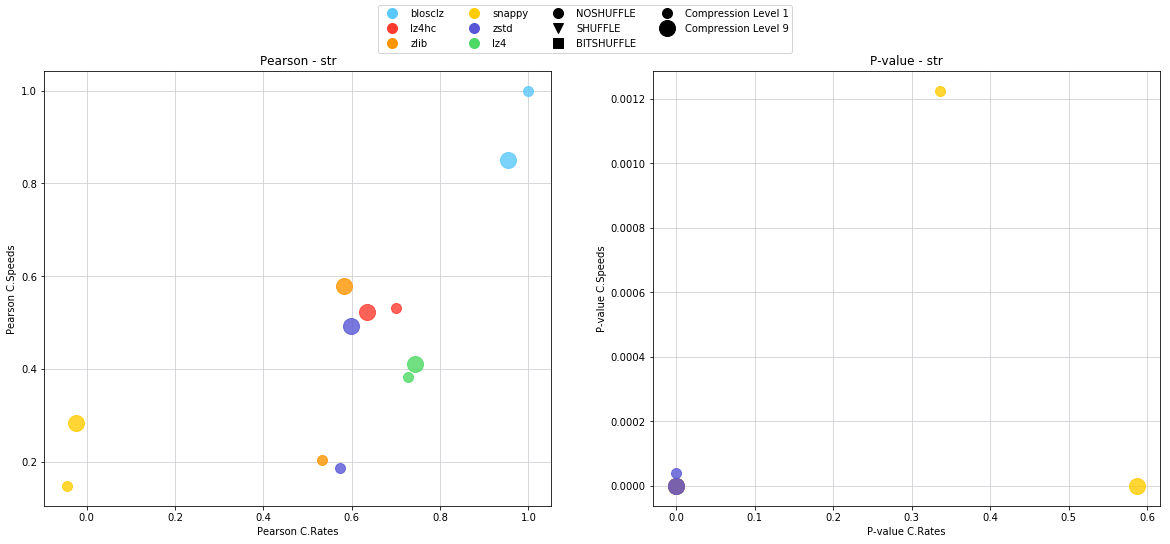

lz4 1 VS


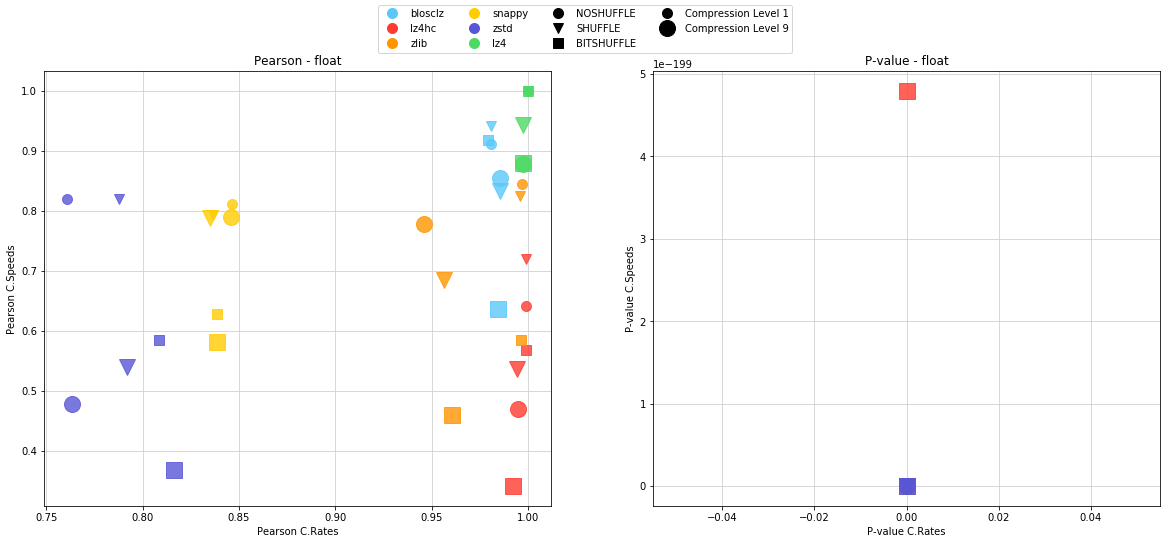

lz4 1 VS


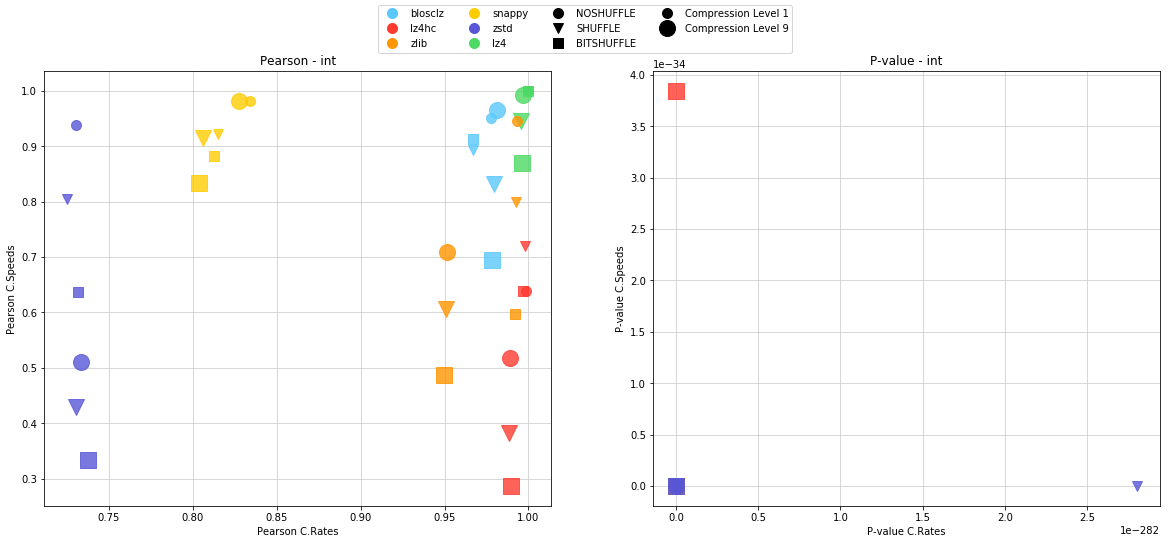

lz4 1 VS


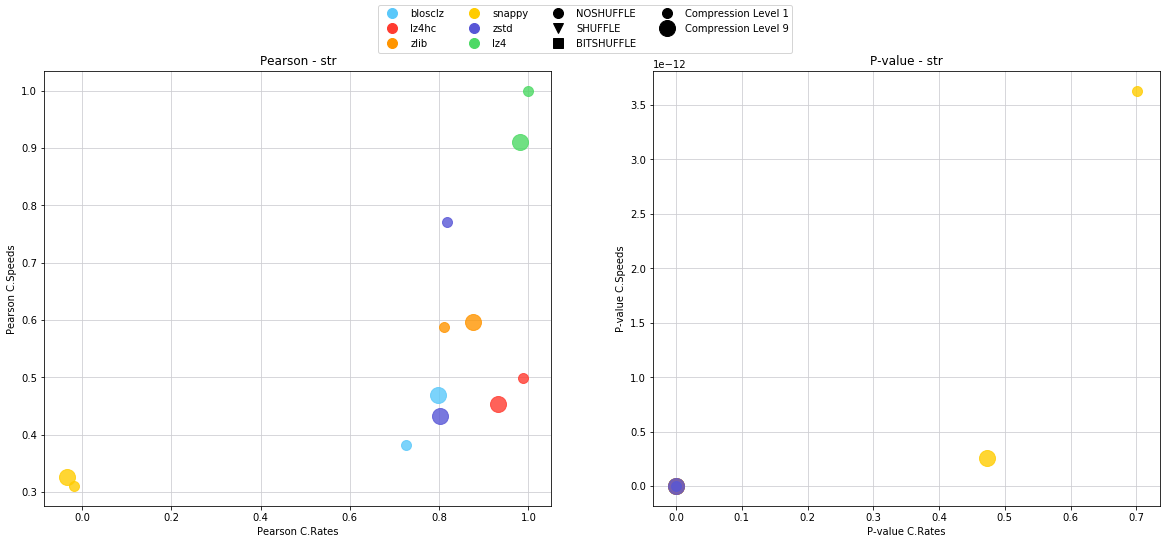

In [12]:
def pearson_cor_data_builder(cname, clevel):
    """Build data for codec correlation graphs."""

    pearson_rates = [[], [], []]
    pearson_c_speeds = [[], [], []]
    codecs_cl = [[], [], []]
    colors = [[], [], []]
    markers = [[], [], []]
    for codec in my_df.drop_duplicates(subset=['Codec'])['Codec']:
        for filt in ['noshuffle', 'shuffle', 'bitshuffle']:
            df_blz1 = my_df[(my_df.Codec == cname) & (my_df.CL == clevel) & (my_df.Filter == filt)]
            for c_level in [1, 9]:
                df_codec = my_df[(my_df.Codec == codec) & (my_df.CL == c_level) & (my_df.Filter == filt)]
                for i in range(3):
                    if i == 2:
                        dfaux = df_codec[df_codec.DType.str.contains('U') | df_codec.DType.str.contains('S')]
                        df_blz_aux = df_blz1[df_blz1.DType.str.contains('U') | df_blz1.DType.str.contains('S')]
                    else:
                        dfaux = df_codec[df_codec.DType.str.contains(TYPES[i])]
                        df_blz_aux = df_blz1[df_blz1.DType.str.contains(TYPES[i])]
                    if dfaux.size > 0:
                        pearson_rates[i].append(pearsonr(df_blz_aux['CRate'], dfaux['CRate']))
                        pearson_c_speeds[i].append(pearsonr(df_blz_aux['CSpeed'], dfaux['CSpeed']))
                        codecs_cl[i].append(codec + '-' + filt + '-' + str(c_level) + '-' + TYPES[i])
                        colors[i].append(COLOR_PALETTE[codec])
                        markers[i].append(MARKER_DICT[filt])

    return pearson_rates, pearson_c_speeds, codecs_cl, colors, markers


def paint_codec_pearson_corr(cname, clevel):
    """Paint custom graphs for codec correlation."""

    pearson_rates, pearson_c_speeds, codecs_cl, colors, markers = pearson_cor_data_builder(cname, clevel)

    for i in range(3):
        if len(pearson_rates[i]) > 0:
            print(cname, clevel, 'VS')
            fig = plt.figure(figsize=(20, 8))
            ax = fig.add_subplot(121)
            custom_pearson_scatter(ax, [x[0] for x in pearson_rates[i]],
                                   [x[0] for x in pearson_c_speeds[i]],
                                   colors[i], markers[i], 'Pearson', TYPES[i])
            ax2 = fig.add_subplot(122)
            custom_pearson_scatter(ax2, [x[1] for x in pearson_rates[i]],
                                   [x[1] for x in pearson_c_speeds[i]],
                                   colors[i], markers[i], 'P-value', TYPES[i])
            custom_sc_legend(fig)
            plt.show()


paint_codec_pearson_corr('blosclz', 1)
paint_codec_pearson_corr('lz4', 1)

## Correlaciones chunk features VS test features

904 points


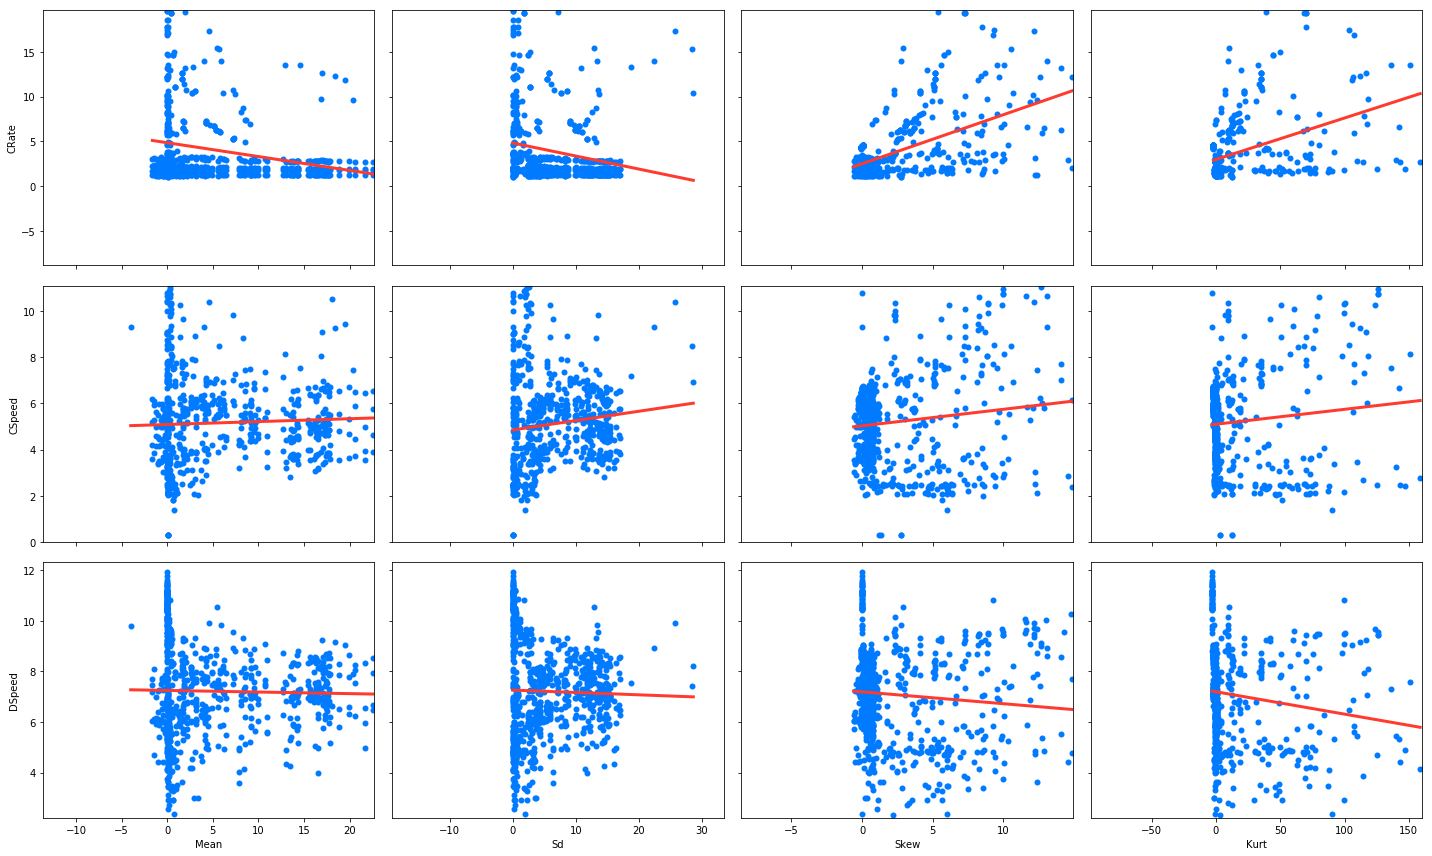

In [13]:
def custom_pairs(df, col_names):
    """Paint scatter matrix plot."""

    print('%d points' % df.shape[0])
    fig, axs = plt.subplots(3, len(col_names), sharex='col', sharey='row')
    fig.set_size_inches(20, 12)
    for j, y in enumerate(['CRate', 'CSpeed', 'DSpeed']):
        for i, x in enumerate(col_names):
            custom_centered_scatter(axs[j, i], df[x], df[y])
            if j == 2:
                axs[j, i].set_xlabel(x)
            if i == 0:
                axs[j, i].set_ylabel(y)
    fig.tight_layout()
    plt.show()


dfaux = my_df[(my_df.Codec == 'lz4') & (my_df.Block_Size == 0) & (my_df.Filter == 'shuffle') &
              (my_df.CL == 5) & (my_df.DType.str.contains('float') | my_df.DType.str.contains('int'))]
cols = ['Mean', 'Sd', 'Skew', 'Kurt']
custom_pairs(dfaux, cols)

904 points


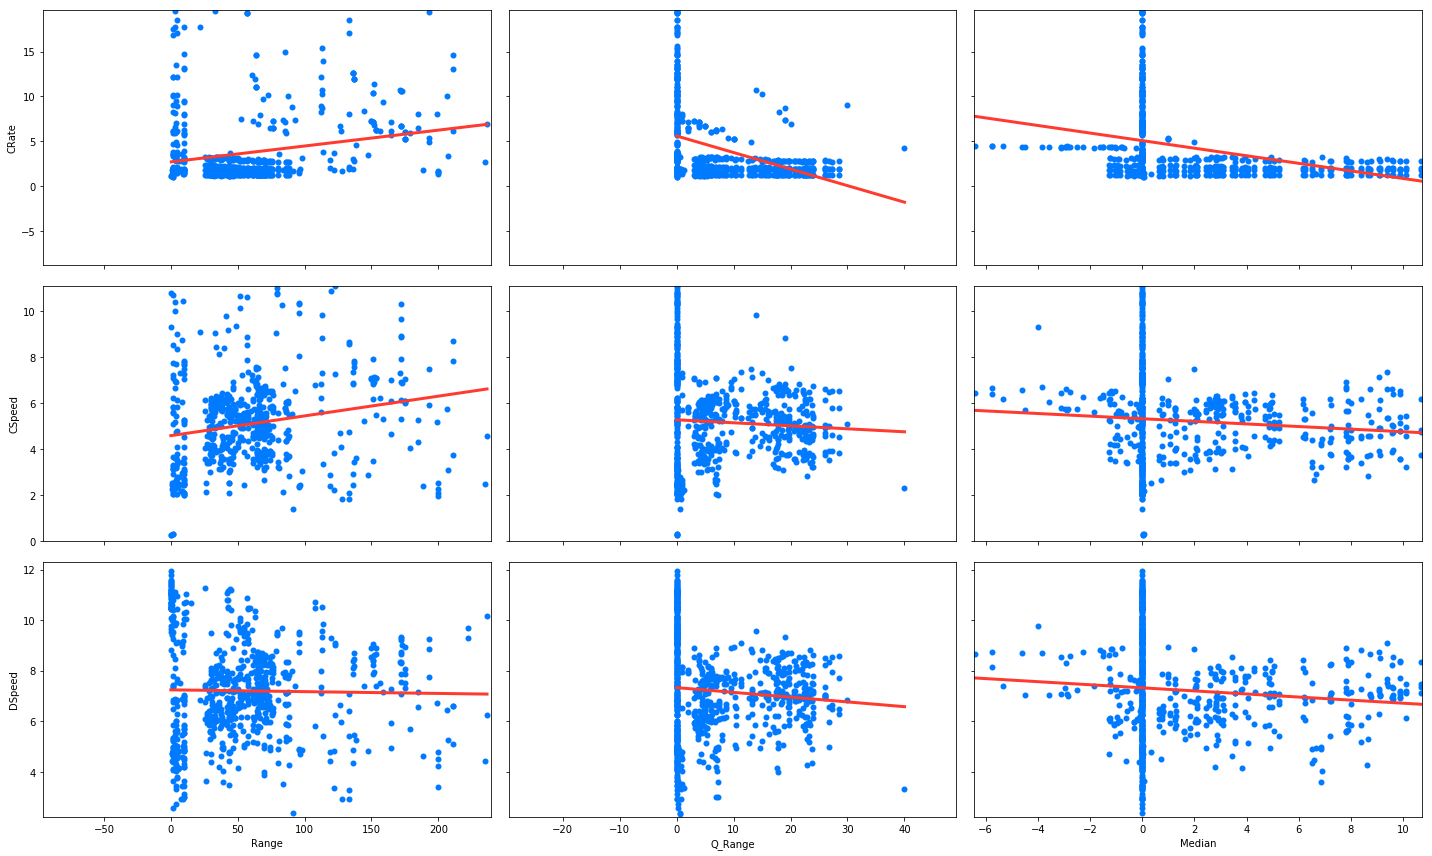

In [14]:
dfaux.is_copy = False
cols = ['Range', 'Q_Range', 'Median']
dfaux.loc[:,'Range'] = dfaux['Max'] - dfaux['Min']
dfaux.loc[:,'Q_Range'] = dfaux['Q3'] - dfaux['Q1']
custom_pairs(dfaux, cols)